In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

# Imports

In [3]:
import configparser

import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import modulephaselib

# Dataset

In [4]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [5]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# I/Q samples to Module/Phase conversion

Each signal is transformed from an I/Q sample to his Module/Phase representation, and added as a column to the dataset.

In [6]:
dataset_df = modulephaselib.transform_and_add_signals_to_dataframe(dataset_df)

## The dataset after adding Module/Phase signals

In [7]:
dataset_df

,IQ signals,Modulation_Label,SNR,MP signals
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2,"([0.009777415810077348, 0.008160794610184235, ..."
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2,"([0.006428271419970337, 0.0018729896699540463,..."
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2,"([0.006714471814517775, 0.010443807990507132, ..."
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2,"([0.0036471206082490607, 0.008847963411403753,..."
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2,"([0.01363757358555227, 0.004953662955395487, 0..."
...,...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18,"([0.007888647836121875, 0.00518580783630137, 0..."
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18,"([0.004378196387910148, 0.006676949935829746, ..."
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18,"([0.013097595344676685, 0.008587072893700217, ..."
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18,"([0.004868425922433083, 0.01011580181134021, 0..."


# Neural network

## Configuration

In [8]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', 'FreeHandV2')
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [9]:
signals = modulephaselib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [10]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [11]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(165000, 2, 128)
[2, 128]


In [12]:
model = neural_networks.freehand_v2(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
dense (Dense)                (None, 2, 128, 256)       4352      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 128, 32)        32800     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 64, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0     

### Train the model

In [13]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/162 [..............................] - ETA: 34:15 - loss: 2.4005

  2/162 [..............................] - ETA: 9s - loss: 2.3978   

  3/162 [..............................] - ETA: 9s - loss: 2.3967

  4/162 [..............................] - ETA: 9s - loss: 2.3951

  5/162 [..............................] - ETA: 9s - loss: 2.3930

  6/162 [>.............................] - ETA: 9s - loss: 2.3911

  7/162 [>.............................] - ETA: 9s - loss: 2.3885

  8/162 [>.............................] - ETA: 9s - loss: 2.3857

  9/162 [>.............................] - ETA: 9s - loss: 2.3823

 10/162 [>.............................] - ETA: 9s - loss: 2.3790

 11/162 [=>............................] - ETA: 9s - loss: 2.3756

 12/162 [=>............................] - ETA: 9s - loss: 2.3720

 13/162 [=>............................] - ETA: 9s - loss: 2.3682

 14/162 [=>............................] - ETA: 9s - loss: 2.3642

 15/162 [=>............................] - ETA: 8s - loss: 2.3603

 16/162 [=>............................] - ETA: 8s - loss: 2.3563

 17/162 [==>...........................] - ETA: 8s - loss: 2.3523

 18/162 [==>...........................] - ETA: 8s - loss: 2.3483

 19/162 [==>...........................] - ETA: 8s - loss: 2.3444

 20/162 [==>...........................] - ETA: 8s - loss: 2.3406

 21/162 [==>...........................] - ETA: 8s - loss: 2.3368

 22/162 [===>..........................] - ETA: 8s - loss: 2.3332

 23/162 [===>..........................] - ETA: 8s - loss: 2.3298

 24/162 [===>..........................] - ETA: 8s - loss: 2.3263

 25/162 [===>..........................] - ETA: 8s - loss: 2.3229

 26/162 [===>..........................] - ETA: 8s - loss: 2.3196

 27/162 [====>.........................] - ETA: 8s - loss: 2.3163

 28/162 [====>.........................] - ETA: 8s - loss: 2.3132

 29/162 [====>.........................] - ETA: 8s - loss: 2.3101

 30/162 [====>.........................] - ETA: 8s - loss: 2.3072

 31/162 [====>.........................] - ETA: 8s - loss: 2.3042

 32/162 [====>.........................] - ETA: 7s - loss: 2.3014

 33/162 [=====>........................] - ETA: 7s - loss: 2.2986

 34/162 [=====>........................]

 - ETA: 7s - loss: 2.2959

 35/162 [=====>........................] - ETA: 7s - loss: 2.2933

 36/162 [=====>........................] - ETA: 7s - loss: 2.2907

 37/162 [=====>........................] - ETA: 7s - loss: 2.2882

 38/162 [======>.......................] - ETA: 7s - loss: 2.2857

 39/162 [======>.......................] - ETA: 7s - loss: 2.2833

 40/162 [======>.......................] - ETA: 7s - loss: 2.2809

 41/162 [======>.......................] - ETA: 7s - loss: 2.2786

 42/162 [======>.......................] - ETA: 7s - loss: 2.2763

 43/162 [======>.......................] - ETA: 7s - loss: 2.2740

 44/162 [=======>......................] - ETA: 7s - loss: 2.2718

 45/162 [=======>......................] - ETA: 7s - loss: 2.2697



 46/162 [=======>......................] - ETA: 7s - loss: 2.2675

 47/162 [=======>......................] - ETA: 7s - loss: 2.2654

 48/162 [=======>......................] - ETA: 6s - loss: 2.2634

 49/162 [========>.....................] - ETA: 6s - loss: 2.2614

 50/162 [========>.....................] - ETA: 6s - loss: 2.2594

 51/162 [========>.....................] - ETA: 6s - loss: 2.2575

 52/162 [========>.....................] - ETA: 6s - loss: 2.2555

 53/162 [========>.....................] - ETA: 6s - loss: 2.2537

 54/162 [=========>....................] - ETA: 6s - loss: 2.2518

 55/162 [=========>....................] - ETA: 6s - loss: 2.2500

 56/162 [=========>....................] - ETA: 6s - loss: 2.2482

 57/162 [=========>....................] - ETA: 6s - loss: 2.2465

 58/162 [=========>....................] - ETA: 6s - loss: 2.2448

 59/162 [=========>....................] - ETA: 6s - loss: 2.2431

 60/162 [==========>...................]

 - ETA: 6s - loss: 2.2414

 61/162 [==========>...................] - ETA: 6s - loss: 2.2398

 62/162 [==========>...................] - ETA: 6s - loss: 2.2381

 63/162 [==========>...................] - ETA: 6s - loss: 2.2365

 64/162 [==========>...................] - ETA: 6s - loss: 2.2350

 65/162 [===========>..................] - ETA: 5s - loss: 2.2334



 66/162 [===========>..................] - ETA: 5s - loss: 2.2319

 67/162 [===========>..................] - ETA: 5s - loss: 2.2304

 68/162 [===========>..................] - ETA: 5s - loss: 2.2289

 69/162 [===========>..................] - ETA: 5s - loss: 2.2274

 70/162 [===========>..................] - ETA: 5s - loss: 2.2260

 71/162 [============>.................] - ETA: 5s - loss: 2.2245

 72/162 [============>.................] - ETA: 5s - loss: 2.2231

 73/162 [============>.................] - ETA: 5s - loss: 2.2217

 74/162 [============>.................] - ETA: 5s - loss: 2.2203

 75/162 [============>.................] - ETA: 5s - loss: 2.2189

 76/162 [=============>................] - ETA: 5s - loss: 2.2175

 77/162 [=============>................] - ETA: 5s - loss: 2.2162

 78/162 [=============>................] - ETA: 5s - loss: 2.2148

 79/162 [=============>................] - ETA: 5s - loss: 2.2135

 80/162 [=============>................] - ETA: 5s - loss: 2.2122

 81/162 [==============>...............] - ETA: 4s - loss: 2.2109

 82/162 [==============>...............] - ETA: 4s - loss: 2.2096

 83/162 [==============>...............] - ETA: 4s - loss: 2.2083

 84/162 [==============>...............] - ETA: 4s - loss: 2.2070

 85/162 [==============>...............] - ETA: 4s - loss: 2.2058

 86/162 [==============>...............] - ETA: 4s - loss: 2.2045

 87/162 [===============>..............] - ETA: 4s - loss: 2.2033

 88/162 [===============>..............] - ETA: 4s - loss: 2.2021

 89/162 [===============>..............] - ETA: 4s - loss: 2.2009

 90/162 [===============>..............] - ETA: 4s - loss: 2.1997

 91/162 [===============>..............] - ETA: 4s - loss: 2.1985

 92/162 [================>.............] - ETA: 4s - loss: 2.1974

 93/162 [================>.............] - ETA: 4s - loss: 2.1962

 94/162 [================>.............] - ETA: 4s - loss: 2.1951

 95/162 [================>.............] - ETA: 4s - loss: 2.1940

 96/162 [================>.............] - ETA: 4s - loss: 2.1928

 97/162 [================>.............] - ETA: 3s - loss: 2.1917

 98/162 [=================>............] - ETA: 3s - loss: 2.1906

 99/162 [=================>............] - ETA: 3s - loss: 2.1895

100/162 [=================>............] - ETA: 3s - loss: 2.1884

101/162 [=================>............] - ETA: 3s - loss: 2.1874

102/162 [=================>............] - ETA: 3s - loss: 2.1863

103/162 [==================>...........] - ETA: 3s - loss: 2.1853

104/162 [==================>...........] - ETA: 3s - loss: 2.1842



105/162 [==================>...........] - ETA: 3s - loss: 2.1832

106/162 [==================>...........] - ETA: 3s - loss: 2.1822

107/162 [==================>...........] - ETA: 3s - loss: 2.1811

108/162 [===================>..........] - ETA: 3s - loss: 2.1801

109/162 [===================>..........] - ETA: 3s - loss: 2.1791

110/162 [===================>..........] - ETA: 3s - loss: 2.1781

111/162 [===================>..........] - ETA: 3s - loss: 2.1771

112/162 [===================>..........] - ETA: 3s - loss: 2.1762

113/162 [===================>..........] - ETA: 3s - loss: 2.1752

114/162 [====================>.........] - ETA: 2s - loss: 2.1742

115/162 [====================>.........] - ETA: 2s - loss: 2.1733

116/162 [====================>.........] - ETA: 2s - loss: 2.1723

117/162 [====================>.........] - ETA: 2s - loss: 2.1714

118/162 [====================>.........] - ETA: 2s - loss: 2.1705

119/162 [=====================>........] - ETA: 2s - loss: 2.1695

120/162 [=====================>........] - ETA: 2s - loss: 2.1686

121/162 [=====================>........] - ETA: 2s - loss: 2.1677

122/162 [=====================>........] - ETA: 2s - loss: 2.1668

123/162 [=====================>........] - ETA: 2s - loss: 2.1659

124/162 [=====================>........] - ETA: 2s - loss: 2.1650

125/162 [======================>.......] - ETA: 2s - loss: 2.1641

126/162 [======================>.......] - ETA: 2s - loss: 2.1632

127/162 [======================>.......] - ETA: 2s - loss: 2.1624

128/162 [======================>.......] - ETA: 2s - loss: 2.1615

129/162 [======================>.......] - ETA: 2s - loss: 2.1606

130/162 [=======================>......] - ETA: 1s - loss: 2.1598

131/162 [=======================>......] - ETA: 1s - loss: 2.1589

132/162 [=======================>......] - ETA: 1s - loss: 2.1581

133/162 [=======================>......] - ETA: 1s - loss: 2.1573

134/162 [=======================>......] - ETA: 1s - loss: 2.1564

135/162 [========================>.....] - ETA: 1s - loss: 2.1556

136/162 [========================>.....] - ETA: 1s - loss: 2.1548

137/162 [========================>.....] - ETA: 1s - loss: 2.1540

138/162 [========================>.....] - ETA: 1s - loss: 2.1532

139/162 [========================>.....] - ETA: 1s - loss: 2.1524

140/162 [========================>.....] - ETA: 1s - loss: 2.1516

141/162 [=========================>....] - ETA: 1s - loss: 2.1508

142/162 [=========================>....] - ETA: 1s - loss: 2.1500

143/162 [=========================>....] - ETA: 1s - loss: 2.1492

144/162 [=========================>....] - ETA: 1s - loss: 2.1484

145/162 [=========================>....] - ETA: 1s - loss: 2.1476

146/162 [==========================>...] - ETA: 0s - loss: 2.1468

147/162 [==========================>...] - ETA: 0s - loss: 2.1461

148/162 [==========================>...] - ETA: 0s - loss: 2.1453

149/162 [==========================>...] - ETA: 0s - loss: 2.1445

150/162 [==========================>...] - ETA: 0s - loss: 2.1438

151/162 [==========================>...] - ETA: 0s - loss: 2.1430

152/162 [===========================>..] - ETA: 0s - loss: 2.1422

153/162 [===========================>..] - ETA: 0s - loss: 2.1415

154/162 [===========================>..] - ETA: 0s - loss: 2.1407

155/162 [===========================>..] - ETA: 0s - loss: 2.1400

156/162 [===========================>..] - ETA: 0s - loss: 2.1392

157/162 [============================>.] - ETA: 0s - loss: 2.1385

158/162 [============================>.] - ETA: 0s - loss: 2.1377

159/162 [============================>.] - ETA: 0s - loss: 2.1370

160/162 [============================>.] - ETA: 0s - loss: 2.1363

161/162 [============================>.] - ETA: 0s - loss: 2.1355

162/162 [==============================] - ETA: 0s - loss: 2.1348

162/162 [==============================] - 25s 73ms/step - loss: 2.1341 - val_loss: 1.8905


Epoch 2/100
  1/162 [..............................] - ETA: 9s - loss: 1.9325

  2/162 [..............................] - ETA: 10s - loss: 1.8980

  3/162 [..............................] - ETA: 9s - loss: 1.8869 

  4/162 [..............................] - ETA: 9s - loss: 1.8764

  5/162 [..............................] - ETA: 9s - loss: 1.8677

  6/162 [>.............................] - ETA: 9s - loss: 1.8619

  7/162 [>.............................] - ETA: 9s - loss: 1.8574

  8/162 [>.............................] - ETA: 9s - loss: 1.8536

  9/162 [>.............................] - ETA: 9s - loss: 1.8505

 10/162 [>.............................] - ETA: 9s - loss: 1.8479

 11/162 [=>............................] - ETA: 9s - loss: 1.8455

 12/162 [=>............................] - ETA: 9s - loss: 1.8434

 13/162 [=>............................] - ETA: 9s - loss: 1.8415

 14/162 [=>............................] - ETA: 9s - loss: 1.8397

 15/162 [=>............................] - ETA: 9s - loss: 1.8380

 16/162 [=>............................] - ETA: 8s - loss: 1.8363

 17/162 [==>...........................] - ETA: 8s - loss: 1.8347



 18/162 [==>...........................] - ETA: 8s - loss: 1.8331

 19/162 [==>...........................] - ETA: 8s - loss: 1.8317

 20/162 [==>...........................] - ETA: 8s - loss: 1.8302



 21/162 [==>...........................] - ETA: 8s - loss: 1.8287

 22/162 [===>..........................] - ETA: 8s - loss: 1.8274

 23/162 [===>..........................] - ETA: 8s - loss: 1.8261

 24/162 [===>..........................] - ETA: 8s - loss: 1.8248

 25/162 [===>..........................] - ETA: 8s - loss: 1.8237

 26/162 [===>..........................] - ETA: 8s - loss: 1.8225

 27/162 [====>.........................] - ETA: 8s - loss: 1.8214

 28/162 [====>.........................] - ETA: 8s - loss: 1.8203

 29/162 [====>.........................] - ETA: 8s - loss: 1.8191

 30/162 [====>.........................] - ETA: 8s - loss: 1.8181

 31/162 [====>.........................] - ETA: 8s - loss: 1.8170

 32/162 [====>.........................] - ETA: 7s - loss: 1.8160

 33/162 [=====>........................] - ETA: 7s - loss: 1.8150

 34/162 [=====>........................] - ETA: 7s - loss: 1.8140

 35/162 [=====>........................] - ETA: 7s - loss: 1.8130

 36/162 [=====>........................] - ETA: 7s - loss: 1.8119

 37/162 [=====>........................] - ETA: 7s - loss: 1.8109

 38/162 [======>.......................] - ETA: 7s - loss: 1.8099

 39/162 [======>.......................] - ETA: 7s - loss: 1.8089

 40/162 [======>.......................] - ETA: 7s - loss: 1.8080

 41/162 [======>.......................] - ETA: 7s - loss: 1.8070

 42/162 [======>.......................] - ETA: 7s - loss: 1.8061

 43/162 [======>.......................] - ETA: 7s - loss: 1.8051

 44/162 [=======>......................] - ETA: 7s - loss: 1.8042

 45/162 [=======>......................] - ETA: 7s - loss: 1.8032

 46/162 [=======>......................] - ETA: 7s - loss: 1.8023

 47/162 [=======>......................] - ETA: 7s - loss: 1.8014

 48/162 [=======>......................] - ETA: 6s - loss: 1.8005

 49/162 [========>.....................] - ETA: 6s - loss: 1.7995

 50/162 [========>.....................] - ETA: 6s - loss: 1.7986

 51/162 [========>.....................] - ETA: 6s - loss: 1.7977

 52/162 [========>.....................] - ETA: 6s - loss: 1.7968



 53/162 [========>.....................] - ETA: 6s - loss: 1.7959

 54/162 [=========>....................] - ETA: 6s - loss: 1.7950

 55/162 [=========>....................] - ETA: 6s - loss: 1.7941

 56/162 [=========>....................] - ETA: 6s - loss: 1.7933

 57/162 [=========>....................] - ETA: 6s - loss: 1.7924

 58/162 [=========>....................] - ETA: 6s - loss: 1.7916

 59/162 [=========>....................] - ETA: 6s - loss: 1.7908

 60/162 [==========>...................] - ETA: 6s - loss: 1.7899

 61/162 [==========>...................] - ETA: 6s - loss: 1.7891

 62/162 [==========>...................] - ETA: 6s - loss: 1.7882

 63/162 [==========>...................] - ETA: 6s - loss: 1.7874

 64/162 [==========>...................] - ETA: 6s - loss: 1.7866

 65/162 [===========>..................] - ETA: 5s - loss: 1.7858

 66/162 [===========>..................] - ETA: 5s - loss: 1.7849

 67/162 [===========>..................] - ETA: 5s - loss: 1.7842

 68/162 [===========>..................] - ETA: 5s - loss: 1.7834

 69/162 [===========>..................] - ETA: 5s - loss: 1.7826

 70/162 [===========>..................] - ETA: 5s - loss: 1.7818

 71/162 [============>.................] - ETA: 5s - loss: 1.7810

 72/162 [============>.................] - ETA: 5s - loss: 1.7803

 73/162 [============>.................] - ETA: 5s - loss: 1.7795

 74/162 [============>.................] - ETA: 5s - loss: 1.7788

 75/162 [============>.................] - ETA: 5s - loss: 1.7781

 76/162 [=============>................] - ETA: 5s - loss: 1.7773

 77/162 [=============>................] - ETA: 5s - loss: 1.7766

 78/162 [=============>................] - ETA: 5s - loss: 1.7759

 79/162 [=============>................] - ETA: 5s - loss: 1.7751

 80/162 [=============>................] - ETA: 5s - loss: 1.7744

 81/162 [==============>...............] - ETA: 4s - loss: 1.7737



 82/162 [==============>...............] - ETA: 4s - loss: 1.7730

 83/162 [==============>...............] - ETA: 4s - loss: 1.7723



 84/162 [==============>...............] - ETA: 4s - loss: 1.7715

 85/162 [==============>...............] - ETA: 4s - loss: 1.7708

 86/162 [==============>...............] - ETA: 4s - loss: 1.7701

 87/162 [===============>..............] - ETA: 4s - loss: 1.7694

 88/162 [===============>..............] - ETA: 4s - loss: 1.7687

 89/162 [===============>..............] - ETA: 4s - loss: 1.7680

 90/162 [===============>..............] - ETA: 4s - loss: 1.7674

 91/162 [===============>..............] - ETA: 4s - loss: 1.7667

 92/162 [================>.............] - ETA: 4s - loss: 1.7660

 93/162 [================>.............] - ETA: 4s - loss: 1.7654

 94/162 [================>.............] - ETA: 4s - loss: 1.7647

 95/162 [================>.............] - ETA: 4s - loss: 1.7640

 96/162 [================>.............] - ETA: 4s - loss: 1.7634

 97/162 [================>.............] - ETA: 3s - loss: 1.7627

 98/162 [=================>............] - ETA: 3s - loss: 1.7621

 99/162 [=================>............] - ETA: 3s - loss: 1.7615

100/162 [=================>............] - ETA: 3s - loss: 1.7608

101/162 [=================>............] - ETA: 3s - loss: 1.7602

102/162 [=================>............] - ETA: 3s - loss: 1.7596

103/162 [==================>...........] - ETA: 3s - loss: 1.7590

104/162 [==================>...........] - ETA: 3s - loss: 1.7584

105/162 [==================>...........] - ETA: 3s - loss: 1.7578

106/162 [==================>...........] - ETA: 3s - loss: 1.7571

107/162 [==================>...........] - ETA: 3s - loss: 1.7566

108/162 [===================>..........] - ETA: 3s - loss: 1.7560

109/162 [===================>..........] - ETA: 3s - loss: 1.7554

110/162 [===================>..........] - ETA: 3s - loss: 1.7548

111/162 [===================>..........] - ETA: 3s - loss: 1.7542

112/162 [===================>..........] - ETA: 3s - loss: 1.7536

113/162 [===================>..........] - ETA: 3s - loss: 1.7531

114/162 [====================>.........] - ETA: 2s - loss: 1.7525

115/162 [====================>.........] - ETA: 2s - loss: 1.7520

116/162 [====================>.........] - ETA: 2s - loss: 1.7514

117/162 [====================>.........] - ETA: 2s - loss: 1.7509

118/162 [====================>.........] - ETA: 2s - loss: 1.7503

119/162 [=====================>........] - ETA: 2s - loss: 1.7498

120/162 [=====================>........] - ETA: 2s - loss: 1.7492

121/162 [=====================>........] - ETA: 2s - loss: 1.7487

122/162 [=====================>........] - ETA: 2s - loss: 1.7481

123/162 [=====================>........] - ETA: 2s - loss: 1.7476

124/162 [=====================>........] - ETA: 2s - loss: 1.7471

125/162 [======================>.......] - ETA: 2s - loss: 1.7466

126/162 [======================>.......] - ETA: 2s - loss: 1.7461

127/162 [======================>.......] - ETA: 2s - loss: 1.7455

128/162 [======================>.......] - ETA: 2s - loss: 1.7450

129/162 [======================>.......] - ETA: 2s - loss: 1.7445

130/162 [=======================>......] - ETA: 1s - loss: 1.7440

131/162 [=======================>......] - ETA: 1s - loss: 1.7435

132/162 [=======================>......] - ETA: 1s - loss: 1.7430

133/162 [=======================>......] - ETA: 1s - loss: 1.7425

134/162 [=======================>......] - ETA: 1s - loss: 1.7421

135/162 [========================>.....] - ETA: 1s - loss: 1.7416

136/162 [========================>.....] - ETA: 1s - loss: 1.7411

137/162 [========================>.....] - ETA: 1s - loss: 1.7406

138/162 [========================>.....] - ETA: 1s - loss: 1.7401

139/162 [========================>.....] - ETA: 1s - loss: 1.7397

140/162 [========================>.....] - ETA: 1s - loss: 1.7392

141/162 [=========================>....] - ETA: 1s - loss: 1.7387

142/162 [=========================>....] - ETA: 1s - loss: 1.7383

143/162 [=========================>....] - ETA: 1s - loss: 1.7378

144/162 [=========================>....] - ETA: 1s - loss: 1.7374

145/162 [=========================>....] - ETA: 1s - loss: 1.7369

146/162 [==========================>...] - ETA: 0s - loss: 1.7365

147/162 [==========================>...] - ETA: 0s - loss: 1.7360

148/162 [==========================>...] - ETA: 0s - loss: 1.7356

149/162 [==========================>...] - ETA: 0s - loss: 1.7351

150/162 [==========================>...] - ETA: 0s - loss: 1.7347

151/162 [==========================>...] - ETA: 0s - loss: 1.7343

152/162 [===========================>..] - ETA: 0s - loss: 1.7338

153/162 [===========================>..] - ETA: 0s - loss: 1.7334

154/162 [===========================>..] - ETA: 0s - loss: 1.7330

155/162 [===========================>..] - ETA: 0s - loss: 1.7325

156/162 [===========================>..] - ETA: 0s - loss: 1.7321

157/162 [============================>.] - ETA: 0s - loss: 1.7317

158/162 [============================>.] - ETA: 0s - loss: 1.7313

159/162 [============================>.] - ETA: 0s - loss: 1.7308

160/162 [============================>.] - ETA: 0s - loss: 1.7304

161/162 [============================>.] - ETA: 0s - loss: 1.7300

162/162 [==============================] - 11s 68ms/step - loss: 1.7292 - val_loss: 1.6115


Epoch 3/100
  1/162 [..............................] - ETA: 10s - loss: 1.5735

  2/162 [..............................] - ETA: 9s - loss: 1.5850 

  3/162 [..............................] - ETA: 9s - loss: 1.5929

  4/162 [..............................] - ETA: 9s - loss: 1.5938

  5/162 [..............................]

 - ETA: 9s - loss: 1.5943

  6/162 [>.............................] - ETA: 9s - loss: 1.5934

  7/162 [>.............................] - ETA: 9s - loss: 1.5928



  8/162 [>.............................] - ETA: 9s - loss: 1.5919

  9/162 [>.............................] - ETA: 9s - loss: 1.5910

 10/162 [>.............................] - ETA: 9s - loss: 1.5900

 11/162 [=>............................] - ETA: 9s - loss: 1.5890

 12/162 [=>............................] - ETA: 9s - loss: 1.5878

 13/162 [=>............................] - ETA: 9s - loss: 1.5869

 14/162 [=>............................] - ETA: 9s - loss: 1.5859

 15/162 [=>............................] - ETA: 9s - loss: 1.5850

 16/162 [=>............................] - ETA: 8s - loss: 1.5842

 17/162 [==>...........................] - ETA: 8s - loss: 1.5834

 18/162 [==>...........................] - ETA: 8s - loss: 1.5828

 19/162 [==>...........................] - ETA: 8s - loss: 1.5823

 20/162 [==>...........................] - ETA: 8s - loss: 1.5819

 21/162 [==>...........................] - ETA: 8s - loss: 1.5815

 22/162 [===>..........................] - ETA: 8s - loss: 1.5813

 23/162 [===>..........................] - ETA: 8s - loss: 1.5810

 24/162 [===>..........................] - ETA: 8s - loss: 1.5808

 25/162 [===>..........................] - ETA: 8s - loss: 1.5805

 26/162 [===>..........................] - ETA: 8s - loss: 1.5802

 27/162 [====>.........................] - ETA: 8s - loss: 1.5798

 28/162 [====>.........................] - ETA: 8s - loss: 1.5794

 29/162 [====>.........................] - ETA: 8s - loss: 1.5791

 30/162 [====>.........................] - ETA: 8s - loss: 1.5787

 31/162 [====>.........................] - ETA: 8s - loss: 1.5784

 32/162 [====>.........................] - ETA: 7s - loss: 1.5781

 33/162 [=====>........................] - ETA: 7s - loss: 1.5778

 34/162 [=====>........................] - ETA: 7s - loss: 1.5775

 35/162 [=====>........................] - ETA: 7s - loss: 1.5773

 36/162 [=====>........................] - ETA: 7s - loss: 1.5770

 37/162 [=====>........................] - ETA: 7s - loss: 1.5767

 38/162 [======>.......................] - ETA: 7s - loss: 1.5765

 39/162 [======>.......................] - ETA: 7s - loss: 1.5762

 40/162 [======>.......................] - ETA: 7s - loss: 1.5759

 41/162 [======>.......................] - ETA: 7s - loss: 1.5756

 42/162 [======>.......................] - ETA: 7s - loss: 1.5754

 43/162 [======>.......................] - ETA: 7s - loss: 1.5752

 44/162 [=======>......................] - ETA: 7s - loss: 1.5749

 45/162 [=======>......................] - ETA: 7s - loss: 1.5746

 46/162 [=======>......................] - ETA: 7s - loss: 1.5744



 47/162 [=======>......................] - ETA: 7s - loss: 1.5742

 48/162 [=======>......................] - ETA: 6s - loss: 1.5741

 49/162 [========>.....................] - ETA: 6s - loss: 1.5739

 50/162 [========>.....................] - ETA: 6s - loss: 1.5737

 51/162 [========>.....................] - ETA: 6s - loss: 1.5735

 52/162 [========>.....................] - ETA: 6s - loss: 1.5733

 53/162 [========>.....................] - ETA: 6s - loss: 1.5730

 54/162 [=========>....................] - ETA: 6s - loss: 1.5729

 55/162 [=========>....................] - ETA: 6s - loss: 1.5727

 56/162 [=========>....................] - ETA: 6s - loss: 1.5725

 57/162 [=========>....................] - ETA: 6s - loss: 1.5723

 58/162 [=========>....................] - ETA: 6s - loss: 1.5721

 59/162 [=========>....................] - ETA: 6s - loss: 1.5719

 60/162 [==========>...................] - ETA: 6s - loss: 1.5718

 61/162 [==========>...................] - ETA: 6s - loss: 1.5716

 62/162 [==========>...................] - ETA: 6s - loss: 1.5714

 63/162 [==========>...................] - ETA: 6s - loss: 1.5713

 64/162 [==========>...................] - ETA: 6s - loss: 1.5711

 65/162 [===========>..................] - ETA: 5s - loss: 1.5710

 66/162 [===========>..................] - ETA: 5s - loss: 1.5708

 67/162 [===========>..................] - ETA: 5s - loss: 1.5707

 68/162 [===========>..................] - ETA: 5s - loss: 1.5706

 69/162 [===========>..................] - ETA: 5s - loss: 1.5704

 70/162 [===========>..................] - ETA: 5s - loss: 1.5703

 71/162 [============>.................]

 - ETA: 5s - loss: 1.5702

 72/162 [============>.................] - ETA: 5s - loss: 1.5701

 73/162 [============>.................] - ETA: 5s - loss: 1.5699

 74/162 [============>.................] - ETA: 5s - loss: 1.5698

 75/162 [============>.................] - ETA: 5s - loss: 1.5697

 76/162 [=============>................] - ETA: 5s - loss: 1.5696

 77/162 [=============>................] - ETA: 5s - loss: 1.5695

 78/162 [=============>................] - ETA: 5s - loss: 1.5694

 79/162 [=============>................] - ETA: 5s - loss: 1.5692

 80/162 [=============>................] - ETA: 5s - loss: 1.5691

 81/162 [==============>...............] - ETA: 4s - loss: 1.5690

 82/162 [==============>...............] - ETA: 4s - loss: 1.5689

 83/162 [==============>...............] - ETA: 4s - loss: 1.5688

 84/162 [==============>...............] - ETA: 4s - loss: 1.5686

 85/162 [==============>...............] - ETA: 4s - loss: 1.5685

 86/162 [==============>...............] - ETA: 4s - loss: 1.5684

 87/162 [===============>..............] - ETA: 4s - loss: 1.5682

 88/162 [===============>..............] - ETA: 4s - loss: 1.5681

 89/162 [===============>..............]

 - ETA: 4s - loss: 1.5680

 90/162 [===============>..............] - ETA: 4s - loss: 1.5679

 91/162 [===============>..............] - ETA: 4s - loss: 1.5678

 92/162 [================>.............] - ETA: 4s - loss: 1.5676

 93/162 [================>.............] - ETA: 4s - loss: 1.5675

 94/162 [================>.............] - ETA: 4s - loss: 1.5674

 95/162 [================>.............] - ETA: 4s - loss: 1.5673

 96/162 [================>.............] - ETA: 4s - loss: 1.5671

 97/162 [================>.............] - ETA: 3s - loss: 1.5670

 98/162 [=================>............] - ETA: 3s - loss: 1.5669

 99/162 [=================>............] - ETA: 3s - loss: 1.5667

100/162 [=================>............] - ETA: 3s - loss: 1.5666

101/162 [=================>............] - ETA: 3s - loss: 1.5665

102/162 [=================>............] - ETA: 3s - loss: 1.5664

103/162 [==================>...........] - ETA: 3s - loss: 1.5662

104/162 [==================>...........] - ETA: 3s - loss: 1.5661

105/162 [==================>...........] - ETA: 3s - loss: 1.5660

106/162 [==================>...........] - ETA: 3s - loss: 1.5659

107/162 [==================>...........] - ETA: 3s - loss: 1.5658

108/162 [===================>..........] - ETA: 3s - loss: 1.5657

109/162 [===================>..........] - ETA: 3s - loss: 1.5656

110/162 [===================>..........] - ETA: 3s - loss: 1.5655

111/162 [===================>..........] - ETA: 3s - loss: 1.5654

112/162 [===================>..........] - ETA: 3s - loss: 1.5653

113/162 [===================>..........] - ETA: 3s - loss: 1.5652

114/162 [====================>.........] - ETA: 2s - loss: 1.5652

115/162 [====================>.........] - ETA: 2s - loss: 1.5651

116/162 [====================>.........] - ETA: 2s - loss: 1.5650

117/162 [====================>.........] - ETA: 2s - loss: 1.5649

118/162 [====================>.........] - ETA: 2s - loss: 1.5648

119/162 [=====================>........] - ETA: 2s - loss: 1.5647

120/162 [=====================>........] - ETA: 2s - loss: 1.5646

121/162 [=====================>........] - ETA: 2s - loss: 1.5645

122/162 [=====================>........] - ETA: 2s - loss: 1.5644

123/162 [=====================>........] - ETA: 2s - loss: 1.5644

124/162 [=====================>........] - ETA: 2s - loss: 1.5643

125/162 [======================>.......] - ETA: 2s - loss: 1.5642

126/162 [======================>.......] - ETA: 2s - loss: 1.5641

127/162 [======================>.......] - ETA: 2s - loss: 1.5640

128/162 [======================>.......] - ETA: 2s - loss: 1.5640

129/162 [======================>.......] - ETA: 2s - loss: 1.5639

130/162 [=======================>......] - ETA: 1s - loss: 1.5638

131/162 [=======================>......] - ETA: 1s - loss: 1.5637

132/162 [=======================>......] - ETA: 1s - loss: 1.5636

133/162 [=======================>......] - ETA: 1s - loss: 1.5636

134/162 [=======================>......] - ETA: 1s - loss: 1.5635

135/162 [========================>.....] - ETA: 1s - loss: 1.5634

136/162 [========================>.....] - ETA: 1s - loss: 1.5633

137/162 [========================>.....] - ETA: 1s - loss: 1.5633

138/162 [========================>.....] - ETA: 1s - loss: 1.5632

139/162 [========================>.....] - ETA: 1s - loss: 1.5631

140/162 [========================>.....] - ETA: 1s - loss: 1.5631

141/162 [=========================>....] - ETA: 1s - loss: 1.5630

142/162 [=========================>....] - ETA: 1s - loss: 1.5629

143/162 [=========================>....] - ETA: 1s - loss: 1.5628

144/162 [=========================>....] - ETA: 1s - loss: 1.5628

145/162 [=========================>....] - ETA: 1s - loss: 1.5627

146/162 [==========================>...] - ETA: 0s - loss: 1.5626

147/162 [==========================>...] - ETA: 0s - loss: 1.5626

148/162 [==========================>...] - ETA: 0s - loss: 1.5625

149/162 [==========================>...] - ETA: 0s - loss: 1.5625

150/162 [==========================>...] - ETA: 0s - loss: 1.5624

151/162 [==========================>...] - ETA: 0s - loss: 1.5623

152/162 [===========================>..] - ETA: 0s - loss: 1.5623

153/162 [===========================>..] - ETA: 0s - loss: 1.5622

154/162 [===========================>..] - ETA: 0s - loss: 1.5621

155/162 [===========================>..] - ETA: 0s - loss: 1.5621

156/162 [===========================>..] - ETA: 0s - loss: 1.5620

157/162 [============================>.] - ETA: 0s - loss: 1.5619

158/162 [============================>.] - ETA: 0s - loss: 1.5619

159/162 [============================>.] - ETA: 0s - loss: 1.5618

160/162 [============================>.] - ETA: 0s - loss: 1.5618

161/162 [============================>.] - ETA: 0s - loss: 1.5617

162/162 [==============================] - 11s 68ms/step - loss: 1.5616 - val_loss: 1.5581


Epoch 4/100
  1/162 [..............................] - ETA: 9s - loss: 1.5515

  2/162 [..............................] - ETA: 10s - loss: 1.5277

  3/162 [..............................] - ETA: 10s - loss: 1.5194

  4/162 [..............................] - ETA: 10s - loss: 1.5159

  5/162 [..............................] - ETA: 10s - loss: 1.5139

  6/162 [>.............................] - ETA: 10s - loss: 1.5117

  7/162 [>.............................] - ETA: 10s - loss: 1.5103

  8/162 [>.............................] - ETA: 10s - loss: 1.5092

  9/162 [>.............................] - ETA: 9s - loss: 1.5087 

 10/162 [>.............................] - ETA: 9s - loss: 1.5083

 11/162 [=>............................] - ETA: 9s - loss: 1.5079

 12/162 [=>............................] - ETA: 9s - loss: 1.5074

 13/162 [=>............................] - ETA: 9s - loss: 1.5072

 14/162 [=>............................] - ETA: 9s - loss: 1.5072

 15/162 [=>............................] - ETA: 9s - loss: 1.5071

 16/162 [=>............................] - ETA: 9s - loss: 1.5070

 17/162 [==>...........................] - ETA: 9s - loss: 1.5070

 18/162 [==>...........................] - ETA: 9s - loss: 1.5069

 19/162 [==>...........................] - ETA: 9s - loss: 1.5068

 20/162 [==>...........................] - ETA: 9s - loss: 1.5067



 21/162 [==>...........................] - ETA: 8s - loss: 1.5066

 22/162 [===>..........................] - ETA: 8s - loss: 1.5067

 23/162 [===>..........................] - ETA: 8s - loss: 1.5067

 24/162 [===>..........................] - ETA: 8s - loss: 1.5068

 25/162 [===>..........................] - ETA: 8s - loss: 1.5069



 26/162 [===>..........................] - ETA: 8s - loss: 1.5070

 27/162 [====>.........................] - ETA: 8s - loss: 1.5071

 28/162 [====>.........................] - ETA: 8s - loss: 1.5072

 29/162 [====>.........................] - ETA: 8s - loss: 1.5074

 30/162 [====>.........................] - ETA: 8s - loss: 1.5075

 31/162 [====>.........................] - ETA: 8s - loss: 1.5075

 32/162 [====>.........................] - ETA: 8s - loss: 1.5076

 33/162 [=====>........................] - ETA: 8s - loss: 1.5076

 34/162 [=====>........................] - ETA: 8s - loss: 1.5077

 35/162 [=====>........................] - ETA: 7s - loss: 1.5078

 36/162 [=====>........................] - ETA: 7s - loss: 1.5078

 37/162 [=====>........................] - ETA: 7s - loss: 1.5078

 38/162 [======>.......................] - ETA: 7s - loss: 1.5079

 39/162 [======>.......................] - ETA: 7s - loss: 1.5080

 40/162 [======>.......................] - ETA: 7s - loss: 1.5080

 41/162 [======>.......................] - ETA: 7s - loss: 1.5080

 42/162 [======>.......................] - ETA: 7s - loss: 1.5081

 43/162 [======>.......................] - ETA: 7s - loss: 1.5081

 44/162 [=======>......................] - ETA: 7s - loss: 1.5081

 45/162 [=======>......................] - ETA: 7s - loss: 1.5081

 46/162 [=======>......................] - ETA: 7s - loss: 1.5082

 47/162 [=======>......................] - ETA: 7s - loss: 1.5082

 48/162 [=======>......................] - ETA: 7s - loss: 1.5082

 49/162 [========>.....................] - ETA: 7s - loss: 1.5083

 50/162 [========>.....................] - ETA: 6s - loss: 1.5083

 51/162 [========>.....................] - ETA: 6s - loss: 1.5083

 52/162 [========>.....................] - ETA: 6s - loss: 1.5083

 53/162 [========>.....................] - ETA: 6s - loss: 1.5083

 54/162 [=========>....................] - ETA: 6s - loss: 1.5082

 55/162 [=========>....................] - ETA: 6s - loss: 1.5082

 56/162 [=========>....................] - ETA: 6s - loss: 1.5082

 57/162 [=========>....................] - ETA: 6s - loss: 1.5082

 58/162 [=========>....................] - ETA: 6s - loss: 1.5082

 59/162 [=========>....................] - ETA: 6s - loss: 1.5081

 60/162 [==========>...................] - ETA: 6s - loss: 1.5081



 61/162 [==========>...................] - ETA: 6s - loss: 1.5081

 62/162 [==========>...................] - ETA: 6s - loss: 1.5080



 63/162 [==========>...................] - ETA: 6s - loss: 1.5080

 64/162 [==========>...................] - ETA: 6s - loss: 1.5079

 65/162 [===========>..................] - ETA: 6s - loss: 1.5079

 66/162 [===========>..................] - ETA: 5s - loss: 1.5078

 67/162 [===========>..................] - ETA: 5s - loss: 1.5078

 68/162 [===========>..................] - ETA: 5s - loss: 1.5077

 69/162 [===========>..................] - ETA: 5s - loss: 1.5076

 70/162 [===========>..................] - ETA: 5s - loss: 1.5076

 71/162 [============>.................] - ETA: 5s - loss: 1.5075

 72/162 [============>.................] - ETA: 5s - loss: 1.5075

 73/162 [============>.................] - ETA: 5s - loss: 1.5074

 74/162 [============>.................] - ETA: 5s - loss: 1.5074

 75/162 [============>.................] - ETA: 5s - loss: 1.5073

 76/162 [=============>................] - ETA: 5s - loss: 1.5073

 77/162 [=============>................] - ETA: 5s - loss: 1.5072

 78/162 [=============>................] - ETA: 5s - loss: 1.5072

 79/162 [=============>................] - ETA: 5s - loss: 1.5072

 80/162 [=============>................] - ETA: 5s - loss: 1.5071

 81/162 [==============>...............] - ETA: 5s - loss: 1.5071

 82/162 [==============>...............] - ETA: 4s - loss: 1.5071

 83/162 [==============>...............] - ETA: 4s - loss: 1.5071

 84/162 [==============>...............] - ETA: 4s - loss: 1.5070

 85/162 [==============>...............] - ETA: 4s - loss: 1.5070

 86/162 [==============>...............] - ETA: 4s - loss: 1.5070

 87/162 [===============>..............] - ETA: 4s - loss: 1.5070

 88/162 [===============>..............] - ETA: 4s - loss: 1.5070

 89/162 [===============>..............] - ETA: 4s - loss: 1.5070

 90/162 [===============>..............] - ETA: 4s - loss: 1.5070

 91/162 [===============>..............] - ETA: 4s - loss: 1.5070

 92/162 [================>.............] - ETA: 4s - loss: 1.5070

 93/162 [================>.............] - ETA: 4s - loss: 1.5070

 94/162 [================>.............] - ETA: 4s - loss: 1.5070

 95/162 [================>.............] - ETA: 4s - loss: 1.5070

 96/162 [================>.............] - ETA: 4s - loss: 1.5070

 97/162 [================>.............] - ETA: 4s - loss: 1.5069

 98/162 [=================>............] - ETA: 3s - loss: 1.5069

 99/162 [=================>............] - ETA: 3s - loss: 1.5069

100/162 [=================>............] - ETA: 3s - loss: 1.5069

101/162 [=================>............] - ETA: 3s - loss: 1.5069

102/162 [=================>............] - ETA: 3s - loss: 1.5069

103/162 [==================>...........] - ETA: 3s - loss: 1.5069

104/162 [==================>...........] - ETA: 3s - loss: 1.5068

105/162 [==================>...........] - ETA: 3s - loss: 1.5068

106/162 [==================>...........] - ETA: 3s - loss: 1.5068

107/162 [==================>...........] - ETA: 3s - loss: 1.5068

108/162 [===================>..........] - ETA: 3s - loss: 1.5067

109/162 [===================>..........] - ETA: 3s - loss: 1.5067

110/162 [===================>..........] - ETA: 3s - loss: 1.5067

111/162 [===================>..........] - ETA: 3s - loss: 1.5067

112/162 [===================>..........] - ETA: 3s - loss: 1.5066

113/162 [===================>..........] - ETA: 3s - loss: 1.5066

114/162 [====================>.........] - ETA: 2s - loss: 1.5065

115/162 [====================>.........] - ETA: 2s - loss: 1.5065

116/162 [====================>.........] - ETA: 2s - loss: 1.5065

117/162 [====================>.........] - ETA: 2s - loss: 1.5064

118/162 [====================>.........] - ETA: 2s - loss: 1.5064

119/162 [=====================>........] - ETA: 2s - loss: 1.5063

120/162 [=====================>........] - ETA: 2s - loss: 1.5063

121/162 [=====================>........] - ETA: 2s - loss: 1.5062

122/162 [=====================>........] - ETA: 2s - loss: 1.5062

123/162 [=====================>........] - ETA: 2s - loss: 1.5061

124/162 [=====================>........] - ETA: 2s - loss: 1.5061

125/162 [======================>.......] - ETA: 2s - loss: 1.5060

126/162 [======================>.......] - ETA: 2s - loss: 1.5060

127/162 [======================>.......] - ETA: 2s - loss: 1.5059

128/162 [======================>.......] - ETA: 2s - loss: 1.5058

129/162 [======================>.......] - ETA: 2s - loss: 1.5058

130/162 [=======================>......] - ETA: 1s - loss: 1.5057

131/162 [=======================>......] - ETA: 1s - loss: 1.5057

132/162 [=======================>......] - ETA: 1s - loss: 1.5056

133/162 [=======================>......] - ETA: 1s - loss: 1.5056

134/162 [=======================>......] - ETA: 1s - loss: 1.5055

135/162 [========================>.....] - ETA: 1s - loss: 1.5054

136/162 [========================>.....] - ETA: 1s - loss: 1.5054

137/162 [========================>.....] - ETA: 1s - loss: 1.5053

138/162 [========================>.....] - ETA: 1s - loss: 1.5052

139/162 [========================>.....] - ETA: 1s - loss: 1.5052

140/162 [========================>.....] - ETA: 1s - loss: 1.5051

141/162 [=========================>....] - ETA: 1s - loss: 1.5050

142/162 [=========================>....] - ETA: 1s - loss: 1.5050

143/162 [=========================>....] - ETA: 1s - loss: 1.5049

144/162 [=========================>....] - ETA: 1s - loss: 1.5048

145/162 [=========================>....] - ETA: 1s - loss: 1.5048

146/162 [==========================>...] - ETA: 0s - loss: 1.5047

147/162 [==========================>...] - ETA: 0s - loss: 1.5046

148/162 [==========================>...] - ETA: 0s - loss: 1.5046

149/162 [==========================>...] - ETA: 0s - loss: 1.5045

150/162 [==========================>...] - ETA: 0s - loss: 1.5044



151/162 [==========================>...] - ETA: 0s - loss: 1.5043

152/162 [===========================>..] - ETA: 0s - loss: 1.5043

153/162 [===========================>..] - ETA: 0s - loss: 1.5042

154/162 [===========================>..] - ETA: 0s - loss: 1.5041

155/162 [===========================>..] - ETA: 0s - loss: 1.5041

156/162 [===========================>..] - ETA: 0s - loss: 1.5040

157/162 [============================>.] - ETA: 0s - loss: 1.5039

158/162 [============================>.] - ETA: 0s - loss: 1.5039

159/162 [============================>.] - ETA: 0s - loss: 1.5038

160/162 [============================>.] - ETA: 0s - loss: 1.5037

161/162 [============================>.] - ETA: 0s - loss: 1.5036

162/162 [==============================] - 11s 69ms/step - loss: 1.5035 - val_loss: 1.4886


Epoch 5/100
  1/162 [..............................] - ETA: 9s - loss: 1.4110

  2/162 [..............................] - ETA: 9s - loss: 1.4215

  3/162 [..............................] - ETA: 9s - loss: 1.4241

  4/162 [..............................] - ETA: 9s - loss: 1.4272

  5/162 [..............................] - ETA: 9s - loss: 1.4318

  6/162 [>.............................] - ETA: 9s - loss: 1.4352

  7/162 [>.............................] - ETA: 9s - loss: 1.4378

  8/162 [>.............................] - ETA: 9s - loss: 1.4406

  9/162 [>.............................] - ETA: 9s - loss: 1.4430

 10/162 [>.............................] - ETA: 9s - loss: 1.4447

 11/162 [=>............................] - ETA: 9s - loss: 1.4460



 12/162 [=>............................] - ETA: 9s - loss: 1.4468



 13/162 [=>............................] - ETA: 9s - loss: 1.4475

 14/162 [=>............................] - ETA: 9s - loss: 1.4481

 15/162 [=>............................] - ETA: 9s - loss: 1.4483

 16/162 [=>............................] - ETA: 8s - loss: 1.4486

 17/162 [==>...........................] - ETA: 8s - loss: 1.4489

 18/162 [==>...........................] - ETA: 8s - loss: 1.4493

 19/162 [==>...........................] - ETA: 8s - loss: 1.4497

 20/162 [==>...........................] - ETA: 8s - loss: 1.4498

 21/162 [==>...........................] - ETA: 8s - loss: 1.4500

 22/162 [===>..........................] - ETA: 8s - loss: 1.4502

 23/162 [===>..........................] - ETA: 8s - loss: 1.4503

 24/162 [===>..........................] - ETA: 8s - loss: 1.4504

 25/162 [===>..........................] - ETA: 8s - loss: 1.4505

 26/162 [===>..........................] - ETA: 8s - loss: 1.4506

 27/162 [====>.........................] - ETA: 8s - loss: 1.4507

 28/162 [====>.........................]

 - ETA: 8s - loss: 1.4508

 29/162 [====>.........................] - ETA: 8s - loss: 1.4508

 30/162 [====>.........................] - ETA: 8s - loss: 1.4508

 31/162 [====>.........................] - ETA: 8s - loss: 1.4507

 32/162 [====>.........................] - ETA: 7s - loss: 1.4507

 33/162 [=====>........................] - ETA: 7s - loss: 1.4505

 34/162 [=====>........................] - ETA: 7s - loss: 1.4503

 35/162 [=====>........................] - ETA: 7s - loss: 1.4502

 36/162 [=====>........................] - ETA: 7s - loss: 1.4500

 37/162 [=====>........................] - ETA: 7s - loss: 1.4498



 38/162 [======>.......................] - ETA: 7s - loss: 1.4496

 39/162 [======>.......................] - ETA: 7s - loss: 1.4494

 40/162 [======>.......................] - ETA: 7s - loss: 1.4493

 41/162 [======>.......................] - ETA: 7s - loss: 1.4491

 42/162 [======>.......................] - ETA: 7s - loss: 1.4489

 43/162 [======>.......................] - ETA: 7s - loss: 1.4487

 44/162 [=======>......................] - ETA: 7s - loss: 1.4486

 45/162 [=======>......................] - ETA: 7s - loss: 1.4485

 46/162 [=======>......................] - ETA: 7s - loss: 1.4484

 47/162 [=======>......................] - ETA: 7s - loss: 1.4482

 48/162 [=======>......................] - ETA: 7s - loss: 1.4482

 49/162 [========>.....................] - ETA: 6s - loss: 1.4480

 50/162 [========>.....................] - ETA: 6s - loss: 1.4479

 51/162 [========>.....................] - ETA: 6s - loss: 1.4478

 52/162 [========>.....................] - ETA: 6s - loss: 1.4477

 53/162 [========>.....................] - ETA: 6s - loss: 1.4476

 54/162 [=========>....................] - ETA: 6s - loss: 1.4474

 55/162 [=========>....................] - ETA: 6s - loss: 1.4473

 56/162 [=========>....................] - ETA: 6s - loss: 1.4472

 57/162 [=========>....................] - ETA: 6s - loss: 1.4471

 58/162 [=========>....................] - ETA: 6s - loss: 1.4469

 59/162 [=========>....................] - ETA: 6s - loss: 1.4468

 60/162 [==========>...................] - ETA: 6s - loss: 1.4467

 61/162 [==========>...................]

 - ETA: 6s - loss: 1.4466

 62/162 [==========>...................] - ETA: 6s - loss: 1.4465

 63/162 [==========>...................]

 - ETA: 6s - loss: 1.4464

 64/162 [==========>...................] - ETA: 6s - loss: 1.4463

 65/162 [===========>..................] - ETA: 5s - loss: 1.4462

 66/162 [===========>..................] - ETA: 5s - loss: 1.4462

 67/162 [===========>..................] - ETA: 5s - loss: 1.4461

 68/162 [===========>..................] - ETA: 5s - loss: 1.4460

 69/162 [===========>..................] - ETA: 5s - loss: 1.4460

 70/162 [===========>..................] - ETA: 5s - loss: 1.4459

 71/162 [============>.................] - ETA: 5s - loss: 1.4458

 72/162 [============>.................] - ETA: 5s - loss: 1.4458

 73/162 [============>.................] - ETA: 5s - loss: 1.4457

 74/162 [============>.................] - ETA: 5s - loss: 1.4456

 75/162 [============>.................] - ETA: 5s - loss: 1.4456

 76/162 [=============>................] - ETA: 5s - loss: 1.4455

 77/162 [=============>................] - ETA: 5s - loss: 1.4454

 78/162 [=============>................] - ETA: 5s - loss: 1.4454

 79/162 [=============>................] - ETA: 5s - loss: 1.4453

 80/162 [=============>................] - ETA: 5s - loss: 1.4453

 81/162 [==============>...............] - ETA: 4s - loss: 1.4452

 82/162 [==============>...............] - ETA: 4s - loss: 1.4451

 83/162 [==============>...............] - ETA: 4s - loss: 1.4451

 84/162 [==============>...............] - ETA: 4s - loss: 1.4450

 85/162 [==============>...............] - ETA: 4s - loss: 1.4450

 86/162 [==============>...............] - ETA: 4s - loss: 1.4449

 87/162 [===============>..............] - ETA: 4s - loss: 1.4448

 88/162 [===============>..............] - ETA: 4s - loss: 1.4448

 89/162 [===============>..............] - ETA: 4s - loss: 1.4447

 90/162 [===============>..............] - ETA: 4s - loss: 1.4447

 91/162 [===============>..............] - ETA: 4s - loss: 1.4447

 92/162 [================>.............] - ETA: 4s - loss: 1.4446

 93/162 [================>.............] - ETA: 4s - loss: 1.4446

 94/162 [================>.............] - ETA: 4s - loss: 1.4446

 95/162 [================>.............] - ETA: 4s - loss: 1.4445

 96/162 [================>.............] - ETA: 4s - loss: 1.4445

 97/162 [================>.............] - ETA: 4s - loss: 1.4445

 98/162 [=================>............] - ETA: 3s - loss: 1.4444

 99/162 [=================>............] - ETA: 3s - loss: 1.4444

100/162 [=================>............] - ETA: 3s - loss: 1.4444

101/162 [=================>............] - ETA: 3s - loss: 1.4443

102/162 [=================>............] - ETA: 3s - loss: 1.4443

103/162 [==================>...........] - ETA: 3s - loss: 1.4443

104/162 [==================>...........] - ETA: 3s - loss: 1.4442

105/162 [==================>...........] - ETA: 3s - loss: 1.4442

106/162 [==================>...........] - ETA: 3s - loss: 1.4442

107/162 [==================>...........] - ETA: 3s - loss: 1.4441

108/162 [===================>..........] - ETA: 3s - loss: 1.4441

109/162 [===================>..........] - ETA: 3s - loss: 1.4441

110/162 [===================>..........] - ETA: 3s - loss: 1.4440

111/162 [===================>..........] - ETA: 3s - loss: 1.4440

112/162 [===================>..........] - ETA: 3s - loss: 1.4440

113/162 [===================>..........] - ETA: 3s - loss: 1.4439

114/162 [====================>.........] - ETA: 2s - loss: 1.4439

115/162 [====================>.........] - ETA: 2s - loss: 1.4439

116/162 [====================>.........] - ETA: 2s - loss: 1.4438

117/162 [====================>.........] - ETA: 2s - loss: 1.4438

118/162 [====================>.........] - ETA: 2s - loss: 1.4438

119/162 [=====================>........] - ETA: 2s - loss: 1.4437

120/162 [=====================>........] - ETA: 2s - loss: 1.4437

121/162 [=====================>........] - ETA: 2s - loss: 1.4437

122/162 [=====================>........] - ETA: 2s - loss: 1.4436

123/162 [=====================>........] - ETA: 2s - loss: 1.4436

124/162 [=====================>........] - ETA: 2s - loss: 1.4436

125/162 [======================>.......] - ETA: 2s - loss: 1.4436

126/162 [======================>.......] - ETA: 2s - loss: 1.4435

127/162 [======================>.......] - ETA: 2s - loss: 1.4435

128/162 [======================>.......] - ETA: 2s - loss: 1.4435

129/162 [======================>.......] - ETA: 2s - loss: 1.4435

130/162 [=======================>......] - ETA: 1s - loss: 1.4435

131/162 [=======================>......] - ETA: 1s - loss: 1.4435

132/162 [=======================>......] - ETA: 1s - loss: 1.4434

133/162 [=======================>......] - ETA: 1s - loss: 1.4434

134/162 [=======================>......] - ETA: 1s - loss: 1.4434

135/162 [========================>.....] - ETA: 1s - loss: 1.4434

136/162 [========================>.....] - ETA: 1s - loss: 1.4434

137/162 [========================>.....] - ETA: 1s - loss: 1.4434

138/162 [========================>.....] - ETA: 1s - loss: 1.4434

139/162 [========================>.....] - ETA: 1s - loss: 1.4433

140/162 [========================>.....] - ETA: 1s - loss: 1.4433

141/162 [=========================>....] - ETA: 1s - loss: 1.4433

142/162 [=========================>....] - ETA: 1s - loss: 1.4433

143/162 [=========================>....] - ETA: 1s - loss: 1.4433

144/162 [=========================>....] - ETA: 1s - loss: 1.4433

145/162 [=========================>....] - ETA: 1s - loss: 1.4432

146/162 [==========================>...] - ETA: 0s - loss: 1.4432

147/162 [==========================>...] - ETA: 0s - loss: 1.4432

148/162 [==========================>...] - ETA: 0s - loss: 1.4432

149/162 [==========================>...] - ETA: 0s - loss: 1.4432

150/162 [==========================>...] - ETA: 0s - loss: 1.4431

151/162 [==========================>...] - ETA: 0s - loss: 1.4431

152/162 [===========================>..] - ETA: 0s - loss: 1.4431

153/162 [===========================>..] - ETA: 0s - loss: 1.4431

154/162 [===========================>..] - ETA: 0s - loss: 1.4431

155/162 [===========================>..] - ETA: 0s - loss: 1.4430

156/162 [===========================>..] - ETA: 0s - loss: 1.4430

157/162 [============================>.] - ETA: 0s - loss: 1.4430

158/162 [============================>.] - ETA: 0s - loss: 1.4430

159/162 [============================>.] - ETA: 0s - loss: 1.4430

160/162 [============================>.] - ETA: 0s - loss: 1.4429

161/162 [============================>.] - ETA: 0s - loss: 1.4429

162/162 [==============================] - 11s 68ms/step - loss: 1.4429 - val_loss: 1.4752


Epoch 6/100
  1/162 [..............................] - ETA: 9s - loss: 1.3399

  2/162 [..............................] - ETA: 9s - loss: 1.3650

  3/162 [..............................] - ETA: 9s - loss: 1.3755

  4/162 [..............................] - ETA: 9s - loss: 1.3799

  5/162 [..............................] - ETA: 9s - loss: 1.3833

  6/162 [>.............................] - ETA: 9s - loss: 1.3865

  7/162 [>.............................] - ETA: 9s - loss: 1.3895

  8/162 [>.............................] - ETA: 9s - loss: 1.3919

  9/162 [>.............................] - ETA: 9s - loss: 1.3943

 10/162 [>.............................] - ETA: 9s - loss: 1.3954

 11/162 [=>............................] - ETA: 9s - loss: 1.3964

 12/162 [=>............................] - ETA: 9s - loss: 1.3970

 13/162 [=>............................] - ETA: 9s - loss: 1.3977

 14/162 [=>............................] - ETA: 9s - loss: 1.3983

 15/162 [=>............................] - ETA: 9s - loss: 1.3988

 16/162 [=>............................] - ETA: 9s - loss: 1.3992

 17/162 [==>...........................] - ETA: 8s - loss: 1.3997

 18/162 [==>...........................] - ETA: 8s - loss: 1.4004

 19/162 [==>...........................] - ETA: 8s - loss: 1.4007

 20/162 [==>...........................] - ETA: 8s - loss: 1.4009

 21/162 [==>...........................] - ETA: 8s - loss: 1.4012

 22/162 [===>..........................] - ETA: 8s - loss: 1.4015

 23/162 [===>..........................] - ETA: 8s - loss: 1.4018

 24/162 [===>..........................] - ETA: 8s - loss: 1.4019

 25/162 [===>..........................] - ETA: 8s - loss: 1.4022

 26/162 [===>..........................] - ETA: 8s - loss: 1.4025

 27/162 [====>.........................] - ETA: 8s - loss: 1.4029

 28/162 [====>.........................] - ETA: 8s - loss: 1.4033

 29/162 [====>.........................] - ETA: 8s - loss: 1.4037

 30/162 [====>.........................] - ETA: 8s - loss: 1.4040

 31/162 [====>.........................] - ETA: 8s - loss: 1.4043

 32/162 [====>.........................] - ETA: 8s - loss: 1.4045

 33/162 [=====>........................] - ETA: 7s - loss: 1.4048

 34/162 [=====>........................] - ETA: 7s - loss: 1.4050

 35/162 [=====>........................] - ETA: 7s - loss: 1.4052

 36/162 [=====>........................] - ETA: 7s - loss: 1.4054

 37/162 [=====>........................] - ETA: 7s - loss: 1.4056

 38/162 [======>.......................] - ETA: 7s - loss: 1.4057

 39/162 [======>.......................] - ETA: 7s - loss: 1.4058

 40/162 [======>.......................] - ETA: 7s - loss: 1.4059

 41/162 [======>.......................] - ETA: 7s - loss: 1.4060

 42/162 [======>.......................] - ETA: 7s - loss: 1.4061

 43/162 [======>.......................] - ETA: 7s - loss: 1.4062

 44/162 [=======>......................] - ETA: 7s - loss: 1.4062

 45/162 [=======>......................] - ETA: 7s - loss: 1.4063

 46/162 [=======>......................] - ETA: 7s - loss: 1.4063

 47/162 [=======>......................] - ETA: 7s - loss: 1.4064

 48/162 [=======>......................] - ETA: 7s - loss: 1.4064

 49/162 [========>.....................] - ETA: 6s - loss: 1.4064

 50/162 [========>.....................] - ETA: 6s - loss: 1.4065

 51/162 [========>.....................] - ETA: 6s - loss: 1.4065

 52/162 [========>.....................] - ETA: 6s - loss: 1.4066

 53/162 [========>.....................] - ETA: 6s - loss: 1.4066

 54/162 [=========>....................] - ETA: 6s - loss: 1.4066

 55/162 [=========>....................] - ETA: 6s - loss: 1.4067

 56/162 [=========>....................] - ETA: 6s - loss: 1.4067

 57/162 [=========>....................] - ETA: 6s - loss: 1.4067

 58/162 [=========>....................] - ETA: 6s - loss: 1.4067

 59/162 [=========>....................] - ETA: 6s - loss: 1.4067

 60/162 [==========>...................] - ETA: 6s - loss: 1.4067

 61/162 [==========>...................] - ETA: 6s - loss: 1.4068

 62/162 [==========>...................] - ETA: 6s - loss: 1.4068

 63/162 [==========>...................] - ETA: 6s - loss: 1.4067

 64/162 [==========>...................] - ETA: 6s - loss: 1.4067

 65/162 [===========>..................] - ETA: 5s - loss: 1.4067

 66/162 [===========>..................] - ETA: 5s - loss: 1.4067

 67/162 [===========>..................] - ETA: 5s - loss: 1.4067

 68/162 [===========>..................] - ETA: 5s - loss: 1.4067

 69/162 [===========>..................] - ETA: 5s - loss: 1.4067

 70/162 [===========>..................] - ETA: 5s - loss: 1.4066

 71/162 [============>.................] - ETA: 5s - loss: 1.4066

 72/162 [============>.................] - ETA: 5s - loss: 1.4066

 73/162 [============>.................] - ETA: 5s - loss: 1.4066

 74/162 [============>.................] - ETA: 5s - loss: 1.4066

 75/162 [============>.................] - ETA: 5s - loss: 1.4066

 76/162 [=============>................] - ETA: 5s - loss: 1.4066

 77/162 [=============>................] - ETA: 5s - loss: 1.4066

 78/162 [=============>................] - ETA: 5s - loss: 1.4066

 79/162 [=============>................] - ETA: 5s - loss: 1.4066

 80/162 [=============>................] - ETA: 5s - loss: 1.4066

 81/162 [==============>...............] - ETA: 4s - loss: 1.4067

 82/162 [==============>...............] - ETA: 4s - loss: 1.4067

 83/162 [==============>...............] - ETA: 4s - loss: 1.4067

 84/162 [==============>...............] - ETA: 4s - loss: 1.4067

 85/162 [==============>...............] - ETA: 4s - loss: 1.4067

 86/162 [==============>...............] - ETA: 4s - loss: 1.4066

 87/162 [===============>..............] - ETA: 4s - loss: 1.4066

 88/162 [===============>..............] - ETA: 4s - loss: 1.4066

 89/162 [===============>..............] - ETA: 4s - loss: 1.4066

 90/162 [===============>..............] - ETA: 4s - loss: 1.4066

 91/162 [===============>..............] - ETA: 4s - loss: 1.4066

 92/162 [================>.............] - ETA: 4s - loss: 1.4065

 93/162 [================>.............] - ETA: 4s - loss: 1.4065

 94/162 [================>.............] - ETA: 4s - loss: 1.4065

 95/162 [================>.............] - ETA: 4s - loss: 1.4064

 96/162 [================>.............] - ETA: 4s - loss: 1.4064

 97/162 [================>.............] - ETA: 4s - loss: 1.4064

 98/162 [=================>............] - ETA: 3s - loss: 1.4063

 99/162 [=================>............] - ETA: 3s - loss: 1.4063

100/162 [=================>............] - ETA: 3s - loss: 1.4063

101/162 [=================>............] - ETA: 3s - loss: 1.4062

102/162 [=================>............] - ETA: 3s - loss: 1.4062

103/162 [==================>...........] - ETA: 3s - loss: 1.4061

104/162 [==================>...........] - ETA: 3s - loss: 1.4061

105/162 [==================>...........] - ETA: 3s - loss: 1.4060

106/162 [==================>...........] - ETA: 3s - loss: 1.4060

107/162 [==================>...........] - ETA: 3s - loss: 1.4059

108/162 [===================>..........] - ETA: 3s - loss: 1.4059

109/162 [===================>..........] - ETA: 3s - loss: 1.4058

110/162 [===================>..........] - ETA: 3s - loss: 1.4058

111/162 [===================>..........] - ETA: 3s - loss: 1.4058

112/162 [===================>..........] - ETA: 3s - loss: 1.4057

113/162 [===================>..........] - ETA: 3s - loss: 1.4057

114/162 [====================>.........] - ETA: 2s - loss: 1.4056

115/162 [====================>.........] - ETA: 2s - loss: 1.4056

116/162 [====================>.........] - ETA: 2s - loss: 1.4056

117/162 [====================>.........] - ETA: 2s - loss: 1.4055

118/162 [====================>.........] - ETA: 2s - loss: 1.4055

119/162 [=====================>........] - ETA: 2s - loss: 1.4054

120/162 [=====================>........] - ETA: 2s - loss: 1.4054

121/162 [=====================>........] - ETA: 2s - loss: 1.4053

122/162 [=====================>........] - ETA: 2s - loss: 1.4053

123/162 [=====================>........] - ETA: 2s - loss: 1.4053

124/162 [=====================>........] - ETA: 2s - loss: 1.4052

125/162 [======================>.......] - ETA: 2s - loss: 1.4052

126/162 [======================>.......] - ETA: 2s - loss: 1.4051

127/162 [======================>.......] - ETA: 2s - loss: 1.4051

128/162 [======================>.......] - ETA: 2s - loss: 1.4050

129/162 [======================>.......] - ETA: 2s - loss: 1.4050

130/162 [=======================>......] - ETA: 1s - loss: 1.4050

131/162 [=======================>......] - ETA: 1s - loss: 1.4049

132/162 [=======================>......] - ETA: 1s - loss: 1.4049

133/162 [=======================>......] - ETA: 1s - loss: 1.4048

134/162 [=======================>......] - ETA: 1s - loss: 1.4048

135/162 [========================>.....] - ETA: 1s - loss: 1.4048

136/162 [========================>.....] - ETA: 1s - loss: 1.4047

137/162 [========================>.....] - ETA: 1s - loss: 1.4047

138/162 [========================>.....] - ETA: 1s - loss: 1.4047

139/162 [========================>.....] - ETA: 1s - loss: 1.4046

140/162 [========================>.....] - ETA: 1s - loss: 1.4046

141/162 [=========================>....] - ETA: 1s - loss: 1.4046

142/162 [=========================>....] - ETA: 1s - loss: 1.4045

143/162 [=========================>....] - ETA: 1s - loss: 1.4045

144/162 [=========================>....] - ETA: 1s - loss: 1.4045

145/162 [=========================>....] - ETA: 1s - loss: 1.4044

146/162 [==========================>...] - ETA: 0s - loss: 1.4044

147/162 [==========================>...] - ETA: 0s - loss: 1.4044

148/162 [==========================>...] - ETA: 0s - loss: 1.4043

149/162 [==========================>...] - ETA: 0s - loss: 1.4043

150/162 [==========================>...] - ETA: 0s - loss: 1.4043

151/162 [==========================>...] - ETA: 0s - loss: 1.4043

152/162 [===========================>..] - ETA: 0s - loss: 1.4042

153/162 [===========================>..] - ETA: 0s - loss: 1.4042

154/162 [===========================>..] - ETA: 0s - loss: 1.4042

155/162 [===========================>..] - ETA: 0s - loss: 1.4041

156/162 [===========================>..] - ETA: 0s - loss: 1.4041

157/162 [============================>.] - ETA: 0s - loss: 1.4041

158/162 [============================>.] - ETA: 0s - loss: 1.4040

159/162 [============================>.] - ETA: 0s - loss: 1.4040

160/162 [============================>.] - ETA: 0s - loss: 1.4040

161/162 [============================>.] - ETA: 0s - loss: 1.4039

162/162 [==============================] - 11s 68ms/step - loss: 1.4038 - val_loss: 1.4640


Epoch 7/100
  1/162 [..............................] - ETA: 9s - loss: 1.3740

  2/162 [..............................] - ETA: 9s - loss: 1.3678

  3/162 [..............................] - ETA: 9s - loss: 1.3665

  4/162 [..............................] - ETA: 9s - loss: 1.3643

  5/162 [..............................] - ETA: 9s - loss: 1.3641

  6/162 [>.............................] - ETA: 9s - loss: 1.3655

  7/162 [>.............................] - ETA: 9s - loss: 1.3663

  8/162 [>.............................] - ETA: 9s - loss: 1.3668

  9/162 [>.............................] - ETA: 9s - loss: 1.3681

 10/162 [>.............................] - ETA: 9s - loss: 1.3689

 11/162 [=>............................] - ETA: 9s - loss: 1.3700

 12/162 [=>............................] - ETA: 9s - loss: 1.3707

 13/162 [=>............................] - ETA: 9s - loss: 1.3709

 14/162 [=>............................] - ETA: 9s - loss: 1.3711

 15/162 [=>............................] - ETA: 9s - loss: 1.3716

 16/162 [=>............................] - ETA: 8s - loss: 1.3719

 17/162 [==>...........................] - ETA: 8s - loss: 1.3720

 18/162 [==>...........................] - ETA: 8s - loss: 1.3722

 19/162 [==>...........................] - ETA: 8s - loss: 1.3723

 20/162 [==>...........................] - ETA: 8s - loss: 1.3723

 21/162 [==>...........................] - ETA: 8s - loss: 1.3723



 22/162 [===>..........................] - ETA: 8s - loss: 1.3722

 23/162 [===>..........................] - ETA: 8s - loss: 1.3721

 24/162 [===>..........................] - ETA: 8s - loss: 1.3720

 25/162 [===>..........................] - ETA: 8s - loss: 1.3719

 26/162 [===>..........................] - ETA: 8s - loss: 1.3718

 27/162 [====>.........................] - ETA: 8s - loss: 1.3716

 28/162 [====>.........................] - ETA: 8s - loss: 1.3715

 29/162 [====>.........................] - ETA: 8s - loss: 1.3713

 30/162 [====>.........................] - ETA: 8s - loss: 1.3712

 31/162 [====>.........................] - ETA: 8s - loss: 1.3710

 32/162 [====>.........................] - ETA: 8s - loss: 1.3708

 33/162 [=====>........................] - ETA: 7s - loss: 1.3706

 34/162 [=====>........................]

 - ETA: 7s - loss: 1.3705

 35/162 [=====>........................] - ETA: 7s - loss: 1.3703

 36/162 [=====>........................] - ETA: 7s - loss: 1.3702

 37/162 [=====>........................] - ETA: 7s - loss: 1.3700

 38/162 [======>.......................] - ETA: 7s - loss: 1.3698

 39/162 [======>.......................] - ETA: 7s - loss: 1.3697

 40/162 [======>.......................] - ETA: 7s - loss: 1.3695

 41/162 [======>.......................] - ETA: 7s - loss: 1.3694

 42/162 [======>.......................] - ETA: 7s - loss: 1.3693

 43/162 [======>.......................] - ETA: 7s - loss: 1.3691

 44/162 [=======>......................] - ETA: 7s - loss: 1.3690

 45/162 [=======>......................] - ETA: 7s - loss: 1.3689

 46/162 [=======>......................] - ETA: 7s - loss: 1.3689

 47/162 [=======>......................] - ETA: 7s - loss: 1.3688

 48/162 [=======>......................] - ETA: 7s - loss: 1.3688

 49/162 [========>.....................] - ETA: 6s - loss: 1.3687

 50/162 [========>.....................] - ETA: 6s - loss: 1.3687

 51/162 [========>.....................] - ETA: 6s - loss: 1.3687

 52/162 [========>.....................] - ETA: 6s - loss: 1.3686

 53/162 [========>.....................] - ETA: 6s - loss: 1.3686

 54/162 [=========>....................] - ETA: 6s - loss: 1.3686

 55/162 [=========>....................] - ETA: 6s - loss: 1.3686

 56/162 [=========>....................] - ETA: 6s - loss: 1.3687

 57/162 [=========>....................] - ETA: 6s - loss: 1.3687

 58/162 [=========>....................] - ETA: 6s - loss: 1.3687

 59/162 [=========>....................] - ETA: 6s - loss: 1.3687

 60/162 [==========>...................] - ETA: 6s - loss: 1.3687

 61/162 [==========>...................] - ETA: 6s - loss: 1.3688

 62/162 [==========>...................] - ETA: 6s - loss: 1.3688

 63/162 [==========>...................] - ETA: 6s - loss: 1.3688

 64/162 [==========>...................] - ETA: 6s - loss: 1.3688

 65/162 [===========>..................] - ETA: 5s - loss: 1.3688

 66/162 [===========>..................] - ETA: 5s - loss: 1.3689

 67/162 [===========>..................] - ETA: 5s - loss: 1.3689

 68/162 [===========>..................] - ETA: 5s - loss: 1.3689

 69/162 [===========>..................] - ETA: 5s - loss: 1.3689

 70/162 [===========>..................] - ETA: 5s - loss: 1.3690

 71/162 [============>.................] - ETA: 5s - loss: 1.3690

 72/162 [============>.................] - ETA: 5s - loss: 1.3690

 73/162 [============>.................] - ETA: 5s - loss: 1.3691

 74/162 [============>.................] - ETA: 5s - loss: 1.3691

 75/162 [============>.................] - ETA: 5s - loss: 1.3691

 76/162 [=============>................] - ETA: 5s - loss: 1.3691

 77/162 [=============>................] - ETA: 5s - loss: 1.3691

 78/162 [=============>................] - ETA: 5s - loss: 1.3691

 79/162 [=============>................] - ETA: 5s - loss: 1.3691

 80/162 [=============>................] - ETA: 5s - loss: 1.3691

 81/162 [==============>...............] - ETA: 4s - loss: 1.3691

 82/162 [==============>...............]

 - ETA: 4s - loss: 1.3691

 83/162 [==============>...............] - ETA: 4s - loss: 1.3691

 84/162 [==============>...............] - ETA: 4s - loss: 1.3691

 85/162 [==============>...............] - ETA: 4s - loss: 1.3691

 86/162 [==============>...............] - ETA: 4s - loss: 1.3691

 87/162 [===============>..............] - ETA: 4s - loss: 1.3691

 88/162 [===============>..............] - ETA: 4s - loss: 1.3692

 89/162 [===============>..............] - ETA: 4s - loss: 1.3692

 90/162 [===============>..............] - ETA: 4s - loss: 1.3692

 91/162 [===============>..............] - ETA: 4s - loss: 1.3692

 92/162 [================>.............] - ETA: 4s - loss: 1.3692

 93/162 [================>.............] - ETA: 4s - loss: 1.3692

 94/162 [================>.............] - ETA: 4s - loss: 1.3692

 95/162 [================>.............] - ETA: 4s - loss: 1.3692

 96/162 [================>.............] - ETA: 4s - loss: 1.3692

 97/162 [================>.............] - ETA: 4s - loss: 1.3692

 98/162 [=================>............] - ETA: 3s - loss: 1.3692

 99/162 [=================>............] - ETA: 3s - loss: 1.3692

100/162 [=================>............] - ETA: 3s - loss: 1.3692

101/162 [=================>............] - ETA: 3s - loss: 1.3692

102/162 [=================>............] - ETA: 3s - loss: 1.3692

103/162 [==================>...........] - ETA: 3s - loss: 1.3691

104/162 [==================>...........] - ETA: 3s - loss: 1.3691

105/162 [==================>...........] - ETA: 3s - loss: 1.3691

106/162 [==================>...........]

 - ETA: 3s - loss: 1.3691

107/162 [==================>...........] - ETA: 3s - loss: 1.3691

108/162 [===================>..........] - ETA: 3s - loss: 1.3691

109/162 [===================>..........] - ETA: 3s - loss: 1.3691



110/162 [===================>..........] - ETA: 3s - loss: 1.3691

111/162 [===================>..........] - ETA: 3s - loss: 1.3690

112/162 [===================>..........] - ETA: 3s - loss: 1.3690

113/162 [===================>..........] - ETA: 3s - loss: 1.3690

114/162 [====================>.........] - ETA: 2s - loss: 1.3690

115/162 [====================>.........] - ETA: 2s - loss: 1.3690

116/162 [====================>.........] - ETA: 2s - loss: 1.3690

117/162 [====================>.........] - ETA: 2s - loss: 1.3690

118/162 [====================>.........] - ETA: 2s - loss: 1.3690

119/162 [=====================>........] - ETA: 2s - loss: 1.3689

120/162 [=====================>........] - ETA: 2s - loss: 1.3689

121/162 [=====================>........] - ETA: 2s - loss: 1.3689

122/162 [=====================>........] - ETA: 2s - loss: 1.3689

123/162 [=====================>........] - ETA: 2s - loss: 1.3689

124/162 [=====================>........] - ETA: 2s - loss: 1.3688

125/162 [======================>.......] - ETA: 2s - loss: 1.3688

126/162 [======================>.......] - ETA: 2s - loss: 1.3688

127/162 [======================>.......] - ETA: 2s - loss: 1.3688

128/162 [======================>.......] - ETA: 2s - loss: 1.3687

129/162 [======================>.......] - ETA: 2s - loss: 1.3687

130/162 [=======================>......] - ETA: 1s - loss: 1.3687

131/162 [=======================>......] - ETA: 1s - loss: 1.3687

132/162 [=======================>......] - ETA: 1s - loss: 1.3686

133/162 [=======================>......] - ETA: 1s - loss: 1.3686

134/162 [=======================>......] - ETA: 1s - loss: 1.3686

135/162 [========================>.....] - ETA: 1s - loss: 1.3686

136/162 [========================>.....] - ETA: 1s - loss: 1.3685

137/162 [========================>.....] - ETA: 1s - loss: 1.3685

138/162 [========================>.....] - ETA: 1s - loss: 1.3685

139/162 [========================>.....] - ETA: 1s - loss: 1.3685

140/162 [========================>.....] - ETA: 1s - loss: 1.3685

141/162 [=========================>....] - ETA: 1s - loss: 1.3685

142/162 [=========================>....] - ETA: 1s - loss: 1.3684

143/162 [=========================>....] - ETA: 1s - loss: 1.3684

144/162 [=========================>....] - ETA: 1s - loss: 1.3684

145/162 [=========================>....] - ETA: 1s - loss: 1.3684

146/162 [==========================>...] - ETA: 0s - loss: 1.3684

147/162 [==========================>...] - ETA: 0s - loss: 1.3684

148/162 [==========================>...] - ETA: 0s - loss: 1.3684

149/162 [==========================>...] - ETA: 0s - loss: 1.3683

150/162 [==========================>...] - ETA: 0s - loss: 1.3683

151/162 [==========================>...] - ETA: 0s - loss: 1.3683

152/162 [===========================>..] - ETA: 0s - loss: 1.3683

153/162 [===========================>..] - ETA: 0s - loss: 1.3683

154/162 [===========================>..] - ETA: 0s - loss: 1.3683

155/162 [===========================>..] - ETA: 0s - loss: 1.3683

156/162 [===========================>..] - ETA: 0s - loss: 1.3683

157/162 [============================>.] - ETA: 0s - loss: 1.3682

158/162 [============================>.] - ETA: 0s - loss: 1.3682

159/162 [============================>.] - ETA: 0s - loss: 1.3682

160/162 [============================>.] - ETA: 0s - loss: 1.3682

161/162 [============================>.] - ETA: 0s - loss: 1.3682

162/162 [==============================] - 11s 69ms/step - loss: 1.3682 - val_loss: 1.4263


Epoch 8/100
  1/162 [..............................]

 - ETA: 9s - loss: 1.2998

  2/162 [..............................] - ETA: 9s - loss: 1.2978

  3/162 [..............................] - ETA: 9s - loss: 1.3069

  4/162 [..............................] - ETA: 9s - loss: 1.3125



  5/162 [..............................] - ETA: 9s - loss: 1.3149

  6/162 [>.............................] - ETA: 9s - loss: 1.3168

  7/162 [>.............................]

 - ETA: 9s - loss: 1.3185

  8/162 [>.............................] - ETA: 9s - loss: 1.3207

  9/162 [>.............................] - ETA: 9s - loss: 1.3223

 10/162 [>.............................] - ETA: 9s - loss: 1.3236

 11/162 [=>............................] - ETA: 9s - loss: 1.3248

 12/162 [=>............................] - ETA: 9s - loss: 1.3259

 13/162 [=>............................] - ETA: 9s - loss: 1.3269

 14/162 [=>............................] - ETA: 9s - loss: 1.3275

 15/162 [=>............................] - ETA: 9s - loss: 1.3280

 16/162 [=>............................] - ETA: 9s - loss: 1.3284

 17/162 [==>...........................] - ETA: 8s - loss: 1.3286

 18/162 [==>...........................] - ETA: 8s - loss: 1.3289

 19/162 [==>...........................] - ETA: 8s - loss: 1.3292

 20/162 [==>...........................] - ETA: 8s - loss: 1.3294

 21/162 [==>...........................] - ETA: 8s - loss: 1.3296

 22/162 [===>..........................] - ETA: 8s - loss: 1.3297

 23/162 [===>..........................] - ETA: 8s - loss: 1.3298

 24/162 [===>..........................] - ETA: 8s - loss: 1.3299

 25/162 [===>..........................] - ETA: 8s - loss: 1.3299

 26/162 [===>..........................] - ETA: 8s - loss: 1.3299

 27/162 [====>.........................]

 - ETA: 8s - loss: 1.3298

 28/162 [====>.........................] - ETA: 8s - loss: 1.3297

 29/162 [====>.........................] - ETA: 8s - loss: 1.3296

 30/162 [====>.........................] - ETA: 8s - loss: 1.3295

 31/162 [====>.........................] - ETA: 8s - loss: 1.3295

 32/162 [====>.........................] - ETA: 8s - loss: 1.3295

 33/162 [=====>........................] - ETA: 7s - loss: 1.3295

 34/162 [=====>........................] - ETA: 7s - loss: 1.3295

 35/162 [=====>........................] - ETA: 7s - loss: 1.3295

 36/162 [=====>........................] - ETA: 7s - loss: 1.3295

 37/162 [=====>........................] - ETA: 7s - loss: 1.3295

 38/162 [======>.......................] - ETA: 7s - loss: 1.3295

 39/162 [======>.......................] - ETA: 7s - loss: 1.3294

 40/162 [======>.......................] - ETA: 7s - loss: 1.3294

 41/162 [======>.......................] - ETA: 7s - loss: 1.3294

 42/162 [======>.......................] - ETA: 7s - loss: 1.3294

 43/162 [======>.......................] - ETA: 7s - loss: 1.3295

 44/162 [=======>......................] - ETA: 7s - loss: 1.3295

 45/162 [=======>......................] - ETA: 7s - loss: 1.3295

 46/162 [=======>......................] - ETA: 7s - loss: 1.3295

 47/162 [=======>......................] - ETA: 7s - loss: 1.3295

 48/162 [=======>......................] - ETA: 7s - loss: 1.3295

 49/162 [========>.....................] - ETA: 6s - loss: 1.3295

 50/162 [========>.....................] - ETA: 6s - loss: 1.3295

 51/162 [========>.....................] - ETA: 6s - loss: 1.3294

 52/162 [========>.....................] - ETA: 6s - loss: 1.3294

 53/162 [========>.....................] - ETA: 6s - loss: 1.3294

 54/162 [=========>....................] - ETA: 6s - loss: 1.3293

 55/162 [=========>....................] - ETA: 6s - loss: 1.3293

 56/162 [=========>....................] - ETA: 6s - loss: 1.3292

 57/162 [=========>....................] - ETA: 6s - loss: 1.3292

 58/162 [=========>....................] - ETA: 6s - loss: 1.3291

 59/162 [=========>....................] - ETA: 6s - loss: 1.3291

 60/162 [==========>...................] - ETA: 6s - loss: 1.3290

 61/162 [==========>...................] - ETA: 6s - loss: 1.3290

 62/162 [==========>...................] - ETA: 6s - loss: 1.3290

 63/162 [==========>...................] - ETA: 6s - loss: 1.3290

 64/162 [==========>...................] - ETA: 6s - loss: 1.3289

 65/162 [===========>..................] - ETA: 5s - loss: 1.3289

 66/162 [===========>..................] - ETA: 5s - loss: 1.3289

 67/162 [===========>..................] - ETA: 5s - loss: 1.3289

 68/162 [===========>..................] - ETA: 5s - loss: 1.3288

 69/162 [===========>..................] - ETA: 5s - loss: 1.3288

 70/162 [===========>..................] - ETA: 5s - loss: 1.3288

 71/162 [============>.................] - ETA: 5s - loss: 1.3288

 72/162 [============>.................] - ETA: 5s - loss: 1.3287

 73/162 [============>.................] - ETA: 5s - loss: 1.3287

 74/162 [============>.................] - ETA: 5s - loss: 1.3287

 75/162 [============>.................] - ETA: 5s - loss: 1.3287

 76/162 [=============>................] - ETA: 5s - loss: 1.3287

 77/162 [=============>................] - ETA: 5s - loss: 1.3286

 78/162 [=============>................] - ETA: 5s - loss: 1.3286

 79/162 [=============>................] - ETA: 5s - loss: 1.3286

 80/162 [=============>................] - ETA: 5s - loss: 1.3286

 81/162 [==============>...............] - ETA: 5s - loss: 1.3286

 82/162 [==============>...............] - ETA: 4s - loss: 1.3285

 83/162 [==============>...............] - ETA: 4s - loss: 1.3285

 84/162 [==============>...............] - ETA: 4s - loss: 1.3285

 85/162 [==============>...............] - ETA: 4s - loss: 1.3285

 86/162 [==============>...............] - ETA: 4s - loss: 1.3285

 87/162 [===============>..............] - ETA: 4s - loss: 1.3284

 88/162 [===============>..............] - ETA: 4s - loss: 1.3284

 89/162 [===============>..............] - ETA: 4s - loss: 1.3284

 90/162 [===============>..............] - ETA: 4s - loss: 1.3284

 91/162 [===============>..............] - ETA: 4s - loss: 1.3284

 92/162 [================>.............] - ETA: 4s - loss: 1.3283

 93/162 [================>.............] - ETA: 4s - loss: 1.3283

 94/162 [================>.............] - ETA: 4s - loss: 1.3283

 95/162 [================>.............] - ETA: 4s - loss: 1.3283

 96/162 [================>.............] - ETA: 4s - loss: 1.3283

 97/162 [================>.............] - ETA: 4s - loss: 1.3283

 98/162 [=================>............] - ETA: 3s - loss: 1.3282

 99/162 [=================>............] - ETA: 3s - loss: 1.3282

100/162 [=================>............] - ETA: 3s - loss: 1.3282

101/162 [=================>............] - ETA: 3s - loss: 1.3282

102/162 [=================>............] - ETA: 3s - loss: 1.3281

103/162 [==================>...........] - ETA: 3s - loss: 1.3281

104/162 [==================>...........] - ETA: 3s - loss: 1.3281

105/162 [==================>...........] - ETA: 3s - loss: 1.3281

106/162 [==================>...........] - ETA: 3s - loss: 1.3280

107/162 [==================>...........] - ETA: 3s - loss: 1.3280

108/162 [===================>..........] - ETA: 3s - loss: 1.3280

109/162 [===================>..........] - ETA: 3s - loss: 1.3280

110/162 [===================>..........] - ETA: 3s - loss: 1.3280

111/162 [===================>..........] - ETA: 3s - loss: 1.3279

112/162 [===================>..........] - ETA: 3s - loss: 1.3279

113/162 [===================>..........] - ETA: 3s - loss: 1.3279

114/162 [====================>.........] - ETA: 2s - loss: 1.3279

115/162 [====================>.........] - ETA: 2s - loss: 1.3279

116/162 [====================>.........] - ETA: 2s - loss: 1.3279

117/162 [====================>.........] - ETA: 2s - loss: 1.3279

118/162 [====================>.........] - ETA: 2s - loss: 1.3279

119/162 [=====================>........] - ETA: 2s - loss: 1.3279

120/162 [=====================>........] - ETA: 2s - loss: 1.3278

121/162 [=====================>........] - ETA: 2s - loss: 1.3278

122/162 [=====================>........] - ETA: 2s - loss: 1.3278

123/162 [=====================>........] - ETA: 2s - loss: 1.3278

124/162 [=====================>........] - ETA: 2s - loss: 1.3278

125/162 [======================>.......] - ETA: 2s - loss: 1.3278

126/162 [======================>.......] - ETA: 2s - loss: 1.3278

127/162 [======================>.......] - ETA: 2s - loss: 1.3278

128/162 [======================>.......] - ETA: 2s - loss: 1.3278

129/162 [======================>.......] - ETA: 2s - loss: 1.3277

130/162 [=======================>......] - ETA: 1s - loss: 1.3277

131/162 [=======================>......] - ETA: 1s - loss: 1.3277

132/162 [=======================>......] - ETA: 1s - loss: 1.3277

133/162 [=======================>......] - ETA: 1s - loss: 1.3277

134/162 [=======================>......] - ETA: 1s - loss: 1.3277

135/162 [========================>.....] - ETA: 1s - loss: 1.3277

136/162 [========================>.....] - ETA: 1s - loss: 1.3276

137/162 [========================>.....] - ETA: 1s - loss: 1.3276

138/162 [========================>.....] - ETA: 1s - loss: 1.3276

139/162 [========================>.....] - ETA: 1s - loss: 1.3276

140/162 [========================>.....] - ETA: 1s - loss: 1.3276

141/162 [=========================>....] - ETA: 1s - loss: 1.3276

142/162 [=========================>....] - ETA: 1s - loss: 1.3276

143/162 [=========================>....] - ETA: 1s - loss: 1.3275

144/162 [=========================>....] - ETA: 1s - loss: 1.3275

145/162 [=========================>....] - ETA: 1s - loss: 1.3275

146/162 [==========================>...] - ETA: 0s - loss: 1.3275

147/162 [==========================>...] - ETA: 0s - loss: 1.3275

148/162 [==========================>...] - ETA: 0s - loss: 1.3275

149/162 [==========================>...] - ETA: 0s - loss: 1.3274

150/162 [==========================>...]

 - ETA: 0s - loss: 1.3274

151/162 [==========================>...] - ETA: 0s - loss: 1.3274

152/162 [===========================>..] - ETA: 0s - loss: 1.3274

153/162 [===========================>..] - ETA: 0s - loss: 1.3274

154/162 [===========================>..] - ETA: 0s - loss: 1.3273

155/162 [===========================>..] - ETA: 0s - loss: 1.3273

156/162 [===========================>..] - ETA: 0s - loss: 1.3273

157/162 [============================>.] - ETA: 0s - loss: 1.3273

158/162 [============================>.] - ETA: 0s - loss: 1.3273

159/162 [============================>.] - ETA: 0s - loss: 1.3272

160/162 [============================>.] - ETA: 0s - loss: 1.3272

161/162 [============================>.] - ETA: 0s - loss: 1.3272

162/162 [==============================] - 11s 69ms/step - loss: 1.3272 - val_loss: 1.4100


Epoch 9/100
  1/162 [..............................] - ETA: 9s - loss: 1.3328

  2/162 [..............................] - ETA: 9s - loss: 1.3257

  3/162 [..............................] - ETA: 9s - loss: 1.3221

  4/162 [..............................] - ETA: 9s - loss: 1.3206

  5/162 [..............................] - ETA: 9s - loss: 1.3181

  6/162 [>.............................] - ETA: 9s - loss: 1.3149

  7/162 [>.............................] - ETA: 9s - loss: 1.3130

  8/162 [>.............................] - ETA: 9s - loss: 1.3110

  9/162 [>.............................] - ETA: 9s - loss: 1.3102

 10/162 [>.............................] - ETA: 9s - loss: 1.3095

 11/162 [=>............................] - ETA: 9s - loss: 1.3088

 12/162 [=>............................] - ETA: 9s - loss: 1.3080

 13/162 [=>............................] - ETA: 9s - loss: 1.3073

 14/162 [=>............................] - ETA: 9s - loss: 1.3066

 15/162 [=>............................] - ETA: 9s - loss: 1.3058

 16/162 [=>............................] - ETA: 9s - loss: 1.3051

 17/162 [==>...........................] - ETA: 8s - loss: 1.3046

 18/162 [==>...........................] - ETA: 8s - loss: 1.3041

 19/162 [==>...........................] - ETA: 8s - loss: 1.3035

 20/162 [==>...........................] - ETA: 8s - loss: 1.3031

 21/162 [==>...........................] - ETA: 8s - loss: 1.3026

 22/162 [===>..........................] - ETA: 8s - loss: 1.3022

 23/162 [===>..........................] - ETA: 8s - loss: 1.3019

 24/162 [===>..........................] - ETA: 8s - loss: 1.3015

 25/162 [===>..........................] - ETA: 8s - loss: 1.3011

 26/162 [===>..........................] - ETA: 8s - loss: 1.3008

 27/162 [====>.........................] - ETA: 8s - loss: 1.3004

 28/162 [====>.........................] - ETA: 8s - loss: 1.3001

 29/162 [====>.........................] - ETA: 8s - loss: 1.2999

 30/162 [====>.........................] - ETA: 8s - loss: 1.2997

 31/162 [====>.........................] - ETA: 8s - loss: 1.2995

 32/162 [====>.........................] - ETA: 8s - loss: 1.2994

 33/162 [=====>........................] - ETA: 7s - loss: 1.2992

 34/162 [=====>........................] - ETA: 7s - loss: 1.2990

 35/162 [=====>........................] - ETA: 7s - loss: 1.2988

 36/162 [=====>........................] - ETA: 7s - loss: 1.2987

 37/162 [=====>........................] - ETA: 7s - loss: 1.2986

 38/162 [======>.......................] - ETA: 7s - loss: 1.2985

 39/162 [======>.......................] - ETA: 7s - loss: 1.2983

 40/162 [======>.......................] - ETA: 7s - loss: 1.2983

 41/162 [======>.......................] - ETA: 7s - loss: 1.2982

 42/162 [======>.......................] - ETA: 7s - loss: 1.2981

 43/162 [======>.......................] - ETA: 7s - loss: 1.2980

 44/162 [=======>......................] - ETA: 7s - loss: 1.2979

 45/162 [=======>......................] - ETA: 7s - loss: 1.2978

 46/162 [=======>......................] - ETA: 7s - loss: 1.2977

 47/162 [=======>......................] - ETA: 7s - loss: 1.2976

 48/162 [=======>......................] - ETA: 7s - loss: 1.2975

 49/162 [========>.....................] - ETA: 6s - loss: 1.2974

 50/162 [========>.....................]

 - ETA: 6s - loss: 1.2972

 51/162 [========>.....................] - ETA: 6s - loss: 1.2971

 52/162 [========>.....................] - ETA: 6s - loss: 1.2970

 53/162 [========>.....................] - ETA: 6s - loss: 1.2969



 54/162 [=========>....................] - ETA: 6s - loss: 1.2968

 55/162 [=========>....................] - ETA: 6s - loss: 1.2967

 56/162 [=========>....................] - ETA: 6s - loss: 1.2966

 57/162 [=========>....................] - ETA: 6s - loss: 1.2965

 58/162 [=========>....................] - ETA: 6s - loss: 1.2964

 59/162 [=========>....................] - ETA: 6s - loss: 1.2963

 60/162 [==========>...................] - ETA: 6s - loss: 1.2962

 61/162 [==========>...................] - ETA: 6s - loss: 1.2961

 62/162 [==========>...................] - ETA: 6s - loss: 1.2960

 63/162 [==========>...................] - ETA: 6s - loss: 1.2959

 64/162 [==========>...................] - ETA: 6s - loss: 1.2958

 65/162 [===========>..................] - ETA: 5s - loss: 1.2957

 66/162 [===========>..................] - ETA: 5s - loss: 1.2956

 67/162 [===========>..................] - ETA: 5s - loss: 1.2955

 68/162 [===========>..................] - ETA: 5s - loss: 1.2954

 69/162 [===========>..................] - ETA: 5s - loss: 1.2952

 70/162 [===========>..................] - ETA: 5s - loss: 1.2951

 71/162 [============>.................] - ETA: 5s - loss: 1.2950

 72/162 [============>.................]

 - ETA: 5s - loss: 1.2949

 73/162 [============>.................] - ETA: 5s - loss: 1.2948

 74/162 [============>.................] - ETA: 5s - loss: 1.2947

 75/162 [============>.................] - ETA: 5s - loss: 1.2946

 76/162 [=============>................] - ETA: 5s - loss: 1.2945

 77/162 [=============>................] - ETA: 5s - loss: 1.2944

 78/162 [=============>................] - ETA: 5s - loss: 1.2943

 79/162 [=============>................] - ETA: 5s - loss: 1.2942

 80/162 [=============>................] - ETA: 5s - loss: 1.2941

 81/162 [==============>...............] - ETA: 4s - loss: 1.2941

 82/162 [==============>...............] - ETA: 4s - loss: 1.2940

 83/162 [==============>...............] - ETA: 4s - loss: 1.2939

 84/162 [==============>...............] - ETA: 4s - loss: 1.2938

 85/162 [==============>...............] - ETA: 4s - loss: 1.2938

 86/162 [==============>...............] - ETA: 4s - loss: 1.2937

 87/162 [===============>..............] - ETA: 4s - loss: 1.2936

 88/162 [===============>..............] - ETA: 4s - loss: 1.2936

 89/162 [===============>..............] - ETA: 4s - loss: 1.2935

 90/162 [===============>..............]

 - ETA: 4s - loss: 1.2935

 91/162 [===============>..............] - ETA: 4s - loss: 1.2934

 92/162 [================>.............] - ETA: 4s - loss: 1.2934

 93/162 [================>.............] - ETA: 4s - loss: 1.2933

 94/162 [================>.............] - ETA: 4s - loss: 1.2933

 95/162 [================>.............] - ETA: 4s - loss: 1.2932

 96/162 [================>.............] - ETA: 4s - loss: 1.2932

 97/162 [================>.............] - ETA: 4s - loss: 1.2931

 98/162 [=================>............] - ETA: 3s - loss: 1.2931

 99/162 [=================>............]

 - ETA: 3s - loss: 1.2930

100/162 [=================>............] - ETA: 3s - loss: 1.2930

101/162 [=================>............] - ETA: 3s - loss: 1.2929

102/162 [=================>............] - ETA: 3s - loss: 1.2929

103/162 [==================>...........] - ETA: 3s - loss: 1.2929

104/162 [==================>...........] - ETA: 3s - loss: 1.2928

105/162 [==================>...........] - ETA: 3s - loss: 1.2928

106/162 [==================>...........] - ETA: 3s - loss: 1.2928

107/162 [==================>...........] - ETA: 3s - loss: 1.2927

108/162 [===================>..........] - ETA: 3s - loss: 1.2927



109/162 [===================>..........] - ETA: 3s - loss: 1.2927

110/162 [===================>..........] - ETA: 3s - loss: 1.2926

111/162 [===================>..........]

 - ETA: 3s - loss: 1.2926

112/162 [===================>..........] - ETA: 3s - loss: 1.2926

113/162 [===================>..........] - ETA: 3s - loss: 1.2925

114/162 [====================>.........] - ETA: 2s - loss: 1.2925

115/162 [====================>.........] - ETA: 2s - loss: 1.2924

116/162 [====================>.........] - ETA: 2s - loss: 1.2924



117/162 [====================>.........] - ETA: 2s - loss: 1.2924

118/162 [====================>.........] - ETA: 2s - loss: 1.2923

119/162 [=====================>........] - ETA: 2s - loss: 1.2923

120/162 [=====================>........] - ETA: 2s - loss: 1.2922

121/162 [=====================>........] - ETA: 2s - loss: 1.2922

122/162 [=====================>........] - ETA: 2s - loss: 1.2922

123/162 [=====================>........] - ETA: 2s - loss: 1.2921

124/162 [=====================>........] - ETA: 2s - loss: 1.2921

125/162 [======================>.......] - ETA: 2s - loss: 1.2921

126/162 [======================>.......] - ETA: 2s - loss: 1.2920

127/162 [======================>.......] - ETA: 2s - loss: 1.2920

128/162 [======================>.......] - ETA: 2s - loss: 1.2920

129/162 [======================>.......] - ETA: 2s - loss: 1.2919

130/162 [=======================>......] - ETA: 1s - loss: 1.2919

131/162 [=======================>......] - ETA: 1s - loss: 1.2919

132/162 [=======================>......] - ETA: 1s - loss: 1.2918

133/162 [=======================>......] - ETA: 1s - loss: 1.2918

134/162 [=======================>......] - ETA: 1s - loss: 1.2918

135/162 [========================>.....] - ETA: 1s - loss: 1.2918

136/162 [========================>.....] - ETA: 1s - loss: 1.2918

137/162 [========================>.....] - ETA: 1s - loss: 1.2917

138/162 [========================>.....] - ETA: 1s - loss: 1.2917

139/162 [========================>.....] - ETA: 1s - loss: 1.2917

140/162 [========================>.....] - ETA: 1s - loss: 1.2917

141/162 [=========================>....] - ETA: 1s - loss: 1.2917

142/162 [=========================>....] - ETA: 1s - loss: 1.2917

143/162 [=========================>....] - ETA: 1s - loss: 1.2917

144/162 [=========================>....] - ETA: 1s - loss: 1.2916

145/162 [=========================>....] - ETA: 1s - loss: 1.2916

146/162 [==========================>...] - ETA: 0s - loss: 1.2916

147/162 [==========================>...] - ETA: 0s - loss: 1.2916

148/162 [==========================>...] - ETA: 0s - loss: 1.2916

149/162 [==========================>...] - ETA: 0s - loss: 1.2916

150/162 [==========================>...] - ETA: 0s - loss: 1.2916



151/162 [==========================>...] - ETA: 0s - loss: 1.2916

152/162 [===========================>..] - ETA: 0s - loss: 1.2916

153/162 [===========================>..] - ETA: 0s - loss: 1.2916

154/162 [===========================>..] - ETA: 0s - loss: 1.2916

155/162 [===========================>..] - ETA: 0s - loss: 1.2916

156/162 [===========================>..] - ETA: 0s - loss: 1.2916

157/162 [============================>.] - ETA: 0s - loss: 1.2916

158/162 [============================>.] - ETA: 0s - loss: 1.2916

159/162 [============================>.] - ETA: 0s - loss: 1.2916

160/162 [============================>.] - ETA: 0s - loss: 1.2916

161/162 [============================>.] - ETA: 0s - loss: 1.2916

162/162 [==============================] - 11s 69ms/step - loss: 1.2916 - val_loss: 1.4144


Epoch 10/100
  1/162 [..............................] - ETA: 9s - loss: 1.2702

  2/162 [..............................] - ETA: 10s - loss: 1.2606

  3/162 [..............................] - ETA: 9s - loss: 1.2685 

  4/162 [..............................] - ETA: 9s - loss: 1.2689

  5/162 [..............................] - ETA: 9s - loss: 1.2695

  6/162 [>.............................] - ETA: 9s - loss: 1.2689

  7/162 [>.............................] - ETA: 9s - loss: 1.2691

  8/162 [>.............................] - ETA: 9s - loss: 1.2689

  9/162 [>.............................] - ETA: 9s - loss: 1.2680

 10/162 [>.............................] - ETA: 9s - loss: 1.2672

 11/162 [=>............................] - ETA: 9s - loss: 1.2669

 12/162 [=>............................] - ETA: 9s - loss: 1.2669

 13/162 [=>............................] - ETA: 9s - loss: 1.2667

 14/162 [=>............................] - ETA: 9s - loss: 1.2667

 15/162 [=>............................] - ETA: 9s - loss: 1.2665

 16/162 [=>............................] - ETA: 9s - loss: 1.2659

 17/162 [==>...........................] - ETA: 8s - loss: 1.2654

 18/162 [==>...........................] - ETA: 8s - loss: 1.2652

 19/162 [==>...........................] - ETA: 8s - loss: 1.2649

 20/162 [==>...........................] - ETA: 8s - loss: 1.2647

 21/162 [==>...........................] - ETA: 8s - loss: 1.2643

 22/162 [===>..........................] - ETA: 8s - loss: 1.2640

 23/162 [===>..........................] - ETA: 8s - loss: 1.2638

 24/162 [===>..........................] - ETA: 8s - loss: 1.2636

 25/162 [===>..........................] - ETA: 8s - loss: 1.2634

 26/162 [===>..........................] - ETA: 8s - loss: 1.2634

 27/162 [====>.........................] - ETA: 8s - loss: 1.2634

 28/162 [====>.........................] - ETA: 8s - loss: 1.2632

 29/162 [====>.........................] - ETA: 8s - loss: 1.2632

 30/162 [====>.........................] - ETA: 8s - loss: 1.2631

 31/162 [====>.........................] - ETA: 8s - loss: 1.2629

 32/162 [====>.........................] - ETA: 8s - loss: 1.2627



 33/162 [=====>........................] - ETA: 7s - loss: 1.2625

 34/162 [=====>........................] - ETA: 7s - loss: 1.2624

 35/162 [=====>........................] - ETA: 7s - loss: 1.2622

 36/162 [=====>........................] - ETA: 7s - loss: 1.2621

 37/162 [=====>........................] - ETA: 7s - loss: 1.2620

 38/162 [======>.......................] - ETA: 7s - loss: 1.2620

 39/162 [======>.......................] - ETA: 7s - loss: 1.2619

 40/162 [======>.......................] - ETA: 7s - loss: 1.2619

 41/162 [======>.......................] - ETA: 7s - loss: 1.2619

 42/162 [======>.......................] - ETA: 7s - loss: 1.2618

 43/162 [======>.......................] - ETA: 7s - loss: 1.2618

 44/162 [=======>......................] - ETA: 7s - loss: 1.2617

 45/162 [=======>......................] - ETA: 7s - loss: 1.2617

 46/162 [=======>......................] - ETA: 7s - loss: 1.2617

 47/162 [=======>......................] - ETA: 7s - loss: 1.2617



 48/162 [=======>......................] - ETA: 7s - loss: 1.2616

 49/162 [========>.....................] - ETA: 6s - loss: 1.2616

 50/162 [========>.....................] - ETA: 6s - loss: 1.2615

 51/162 [========>.....................] - ETA: 6s - loss: 1.2615

 52/162 [========>.....................] - ETA: 6s - loss: 1.2614

 53/162 [========>.....................] - ETA: 6s - loss: 1.2614

 54/162 [=========>....................] - ETA: 6s - loss: 1.2614

 55/162 [=========>....................] - ETA: 6s - loss: 1.2613

 56/162 [=========>....................] - ETA: 6s - loss: 1.2613

 57/162 [=========>....................] - ETA: 6s - loss: 1.2613

 58/162 [=========>....................] - ETA: 6s - loss: 1.2613

 59/162 [=========>....................] - ETA: 6s - loss: 1.2613

 60/162 [==========>...................] - ETA: 6s - loss: 1.2612

 61/162 [==========>...................] - ETA: 6s - loss: 1.2612

 62/162 [==========>...................] - ETA: 6s - loss: 1.2613

 63/162 [==========>...................] - ETA: 6s - loss: 1.2613

 64/162 [==========>...................] - ETA: 6s - loss: 1.2613

 65/162 [===========>..................] - ETA: 5s - loss: 1.2613

 66/162 [===========>..................] - ETA: 5s - loss: 1.2613

 67/162 [===========>..................] - ETA: 5s - loss: 1.2614

 68/162 [===========>..................] - ETA: 5s - loss: 1.2614

 69/162 [===========>..................] - ETA: 5s - loss: 1.2614

 70/162 [===========>..................] - ETA: 5s - loss: 1.2614



 71/162 [============>.................] - ETA: 5s - loss: 1.2614

 72/162 [============>.................] - ETA: 5s - loss: 1.2614

 73/162 [============>.................] - ETA: 5s - loss: 1.2614

 74/162 [============>.................] - ETA: 5s - loss: 1.2614

 75/162 [============>.................] - ETA: 5s - loss: 1.2615

 76/162 [=============>................] - ETA: 5s - loss: 1.2615

 77/162 [=============>................] - ETA: 5s - loss: 1.2615

 78/162 [=============>................] - ETA: 5s - loss: 1.2615

 79/162 [=============>................] - ETA: 5s - loss: 1.2615

 80/162 [=============>................] - ETA: 5s - loss: 1.2615

 81/162 [==============>...............] - ETA: 5s - loss: 1.2615

 82/162 [==============>...............] - ETA: 4s - loss: 1.2615

 83/162 [==============>...............] - ETA: 4s - loss: 1.2616

 84/162 [==============>...............] - ETA: 4s - loss: 1.2616

 85/162 [==============>...............] - ETA: 4s - loss: 1.2616

 86/162 [==============>...............] - ETA: 4s - loss: 1.2616

 87/162 [===============>..............] - ETA: 4s - loss: 1.2616

 88/162 [===============>..............] - ETA: 4s - loss: 1.2616

 89/162 [===============>..............] - ETA: 4s - loss: 1.2616

 90/162 [===============>..............] - ETA: 4s - loss: 1.2617

 91/162 [===============>..............] - ETA: 4s - loss: 1.2617

 92/162 [================>.............] - ETA: 4s - loss: 1.2617

 93/162 [================>.............] - ETA: 4s - loss: 1.2617

 94/162 [================>.............] - ETA: 4s - loss: 1.2617

 95/162 [================>.............] - ETA: 4s - loss: 1.2617

 96/162 [================>.............] - ETA: 4s - loss: 1.2618

 97/162 [================>.............] - ETA: 4s - loss: 1.2618

 98/162 [=================>............] - ETA: 3s - loss: 1.2618

 99/162 [=================>............] - ETA: 3s - loss: 1.2618

100/162 [=================>............] - ETA: 3s - loss: 1.2619

101/162 [=================>............] - ETA: 3s - loss: 1.2619

102/162 [=================>............] - ETA: 3s - loss: 1.2619

103/162 [==================>...........] - ETA: 3s - loss: 1.2619

104/162 [==================>...........] - ETA: 3s - loss: 1.2620

105/162 [==================>...........] - ETA: 3s - loss: 1.2620

106/162 [==================>...........] - ETA: 3s - loss: 1.2620

107/162 [==================>...........] - ETA: 3s - loss: 1.2620



108/162 [===================>..........] - ETA: 3s - loss: 1.2621

109/162 [===================>..........] - ETA: 3s - loss: 1.2621

110/162 [===================>..........] - ETA: 3s - loss: 1.2621

111/162 [===================>..........] - ETA: 3s - loss: 1.2621

112/162 [===================>..........] - ETA: 3s - loss: 1.2621

113/162 [===================>..........] - ETA: 3s - loss: 1.2622

114/162 [====================>.........] - ETA: 2s - loss: 1.2622

115/162 [====================>.........]

 - ETA: 2s - loss: 1.2622

116/162 [====================>.........] - ETA: 2s - loss: 1.2622

117/162 [====================>.........] - ETA: 2s - loss: 1.2622

118/162 [====================>.........] - ETA: 2s - loss: 1.2623

119/162 [=====================>........] - ETA: 2s - loss: 1.2623

120/162 [=====================>........] - ETA: 2s - loss: 1.2623

121/162 [=====================>........] - ETA: 2s - loss: 1.2623

122/162 [=====================>........] - ETA: 2s - loss: 1.2623

123/162 [=====================>........] - ETA: 2s - loss: 1.2624

124/162 [=====================>........] - ETA: 2s - loss: 1.2624

125/162 [======================>.......] - ETA: 2s - loss: 1.2624

126/162 [======================>.......] - ETA: 2s - loss: 1.2624

127/162 [======================>.......] - ETA: 2s - loss: 1.2625

128/162 [======================>.......] - ETA: 2s - loss: 1.2625

129/162 [======================>.......] - ETA: 2s - loss: 1.2625

130/162 [=======================>......] - ETA: 1s - loss: 1.2625

131/162 [=======================>......] - ETA: 1s - loss: 1.2626

132/162 [=======================>......] - ETA: 1s - loss: 1.2626

133/162 [=======================>......] - ETA: 1s - loss: 1.2626

134/162 [=======================>......] - ETA: 1s - loss: 1.2626

135/162 [========================>.....] - ETA: 1s - loss: 1.2626

136/162 [========================>.....] - ETA: 1s - loss: 1.2627

137/162 [========================>.....] - ETA: 1s - loss: 1.2627

138/162 [========================>.....] - ETA: 1s - loss: 1.2627

139/162 [========================>.....] - ETA: 1s - loss: 1.2627

140/162 [========================>.....] - ETA: 1s - loss: 1.2627

141/162 [=========================>....] - ETA: 1s - loss: 1.2628

142/162 [=========================>....] - ETA: 1s - loss: 1.2628

143/162 [=========================>....] - ETA: 1s - loss: 1.2628



144/162 [=========================>....] - ETA: 1s - loss: 1.2628

145/162 [=========================>....] - ETA: 1s - loss: 1.2628

146/162 [==========================>...] - ETA: 0s - loss: 1.2629



147/162 [==========================>...] - ETA: 0s - loss: 1.2629

148/162 [==========================>...] - ETA: 0s - loss: 1.2629

149/162 [==========================>...] - ETA: 0s - loss: 1.2629

150/162 [==========================>...] - ETA: 0s - loss: 1.2629



151/162 [==========================>...] - ETA: 0s - loss: 1.2630

152/162 [===========================>..] - ETA: 0s - loss: 1.2630

153/162 [===========================>..] - ETA: 0s - loss: 1.2630

154/162 [===========================>..] - ETA: 0s - loss: 1.2630

155/162 [===========================>..] - ETA: 0s - loss: 1.2631

156/162 [===========================>..] - ETA: 0s - loss: 1.2631

157/162 [============================>.] - ETA: 0s - loss: 1.2631

158/162 [============================>.] - ETA: 0s - loss: 1.2631

159/162 [============================>.] - ETA: 0s - loss: 1.2631

160/162 [============================>.] - ETA: 0s - loss: 1.2632

161/162 [============================>.] - ETA: 0s - loss: 1.2632

162/162 [==============================] - 11s 69ms/step - loss: 1.2632 - val_loss: 1.4090


Epoch 11/100
  1/162 [..............................] - ETA: 9s - loss: 1.2783

  2/162 [..............................] - ETA: 9s - loss: 1.2752

  3/162 [..............................] - ETA: 9s - loss: 1.2714

  4/162 [..............................] - ETA: 9s - loss: 1.2667

  5/162 [..............................] - ETA: 9s - loss: 1.2606

  6/162 [>.............................] - ETA: 9s - loss: 1.2567

  7/162 [>.............................] - ETA: 9s - loss: 1.2549

  8/162 [>.............................] - ETA: 9s - loss: 1.2535

  9/162 [>.............................] - ETA: 9s - loss: 1.2516

 10/162 [>.............................] - ETA: 9s - loss: 1.2502

 11/162 [=>............................] - ETA: 9s - loss: 1.2489

 12/162 [=>............................] - ETA: 9s - loss: 1.2480

 13/162 [=>............................] - ETA: 9s - loss: 1.2472

 14/162 [=>............................] - ETA: 9s - loss: 1.2466

 15/162 [=>............................] - ETA: 9s - loss: 1.2460

 16/162 [=>............................] - ETA: 9s - loss: 1.2453

 17/162 [==>...........................] - ETA: 8s - loss: 1.2446

 18/162 [==>...........................] - ETA: 8s - loss: 1.2438

 19/162 [==>...........................] - ETA: 8s - loss: 1.2430

 20/162 [==>...........................] - ETA: 8s - loss: 1.2423

 21/162 [==>...........................] - ETA: 8s - loss: 1.2416

 22/162 [===>..........................] - ETA: 8s - loss: 1.2409

 23/162 [===>..........................] - ETA: 8s - loss: 1.2403

 24/162 [===>..........................] - ETA: 8s - loss: 1.2396

 25/162 [===>..........................] - ETA: 8s - loss: 1.2390

 26/162 [===>..........................] - ETA: 8s - loss: 1.2384

 27/162 [====>.........................] - ETA: 8s - loss: 1.2379

 28/162 [====>.........................] - ETA: 8s - loss: 1.2375

 29/162 [====>.........................] - ETA: 8s - loss: 1.2371

 30/162 [====>.........................] - ETA: 8s - loss: 1.2368

 31/162 [====>.........................] - ETA: 8s - loss: 1.2365

 32/162 [====>.........................] - ETA: 8s - loss: 1.2362



 33/162 [=====>........................] - ETA: 8s - loss: 1.2360

 34/162 [=====>........................] - ETA: 8s - loss: 1.2358

 35/162 [=====>........................] - ETA: 7s - loss: 1.2356

 36/162 [=====>........................] - ETA: 7s - loss: 1.2355

 37/162 [=====>........................] - ETA: 7s - loss: 1.2353

 38/162 [======>.......................] - ETA: 7s - loss: 1.2352

 39/162 [======>.......................] - ETA: 7s - loss: 1.2350

 40/162 [======>.......................] - ETA: 7s - loss: 1.2349

 41/162 [======>.......................] - ETA: 7s - loss: 1.2348

 42/162 [======>.......................] - ETA: 7s - loss: 1.2347

 43/162 [======>.......................] - ETA: 7s - loss: 1.2347

 44/162 [=======>......................] - ETA: 7s - loss: 1.2346

 45/162 [=======>......................] - ETA: 7s - loss: 1.2345

 46/162 [=======>......................] - ETA: 7s - loss: 1.2345

 47/162 [=======>......................] - ETA: 7s - loss: 1.2344

 48/162 [=======>......................] - ETA: 7s - loss: 1.2344

 49/162 [========>.....................] - ETA: 7s - loss: 1.2344

 50/162 [========>.....................] - ETA: 6s - loss: 1.2344

 51/162 [========>.....................] - ETA: 6s - loss: 1.2344

 52/162 [========>.....................] - ETA: 6s - loss: 1.2344

 53/162 [========>.....................] - ETA: 6s - loss: 1.2344

 54/162 [=========>....................] - ETA: 6s - loss: 1.2343

 55/162 [=========>....................] - ETA: 6s - loss: 1.2343

 56/162 [=========>....................] - ETA: 6s - loss: 1.2343

 57/162 [=========>....................] - ETA: 6s - loss: 1.2344

 58/162 [=========>....................] - ETA: 6s - loss: 1.2344

 59/162 [=========>....................] - ETA: 6s - loss: 1.2344

 60/162 [==========>...................] - ETA: 6s - loss: 1.2344

 61/162 [==========>...................] - ETA: 6s - loss: 1.2344

 62/162 [==========>...................] - ETA: 6s - loss: 1.2344

 63/162 [==========>...................] - ETA: 6s - loss: 1.2344

 64/162 [==========>...................] - ETA: 6s - loss: 1.2345

 65/162 [===========>..................] - ETA: 6s - loss: 1.2345

 66/162 [===========>..................] - ETA: 5s - loss: 1.2345

 67/162 [===========>..................] - ETA: 5s - loss: 1.2345

 68/162 [===========>..................] - ETA: 5s - loss: 1.2345

 69/162 [===========>..................] - ETA: 5s - loss: 1.2345

 70/162 [===========>..................] - ETA: 5s - loss: 1.2345

 71/162 [============>.................] - ETA: 5s - loss: 1.2345

 72/162 [============>.................] - ETA: 5s - loss: 1.2345

 73/162 [============>.................] - ETA: 5s - loss: 1.2344

 74/162 [============>.................] - ETA: 5s - loss: 1.2344

 75/162 [============>.................] - ETA: 5s - loss: 1.2344

 76/162 [=============>................] - ETA: 5s - loss: 1.2344

 77/162 [=============>................] - ETA: 5s - loss: 1.2344

 78/162 [=============>................] - ETA: 5s - loss: 1.2344

 79/162 [=============>................] - ETA: 5s - loss: 1.2344

 80/162 [=============>................] - ETA: 5s - loss: 1.2344

 81/162 [==============>...............] - ETA: 5s - loss: 1.2344

 82/162 [==============>...............] - ETA: 4s - loss: 1.2344

 83/162 [==============>...............] - ETA: 4s - loss: 1.2344

 84/162 [==============>...............] - ETA: 4s - loss: 1.2344

 85/162 [==============>...............] - ETA: 4s - loss: 1.2344

 86/162 [==============>...............] - ETA: 4s - loss: 1.2344

 87/162 [===============>..............] - ETA: 4s - loss: 1.2344

 88/162 [===============>..............] - ETA: 4s - loss: 1.2344

 89/162 [===============>..............] - ETA: 4s - loss: 1.2344

 90/162 [===============>..............] - ETA: 4s - loss: 1.2344

 91/162 [===============>..............] - ETA: 4s - loss: 1.2344

 92/162 [================>.............] - ETA: 4s - loss: 1.2344

 93/162 [================>.............] - ETA: 4s - loss: 1.2344

 94/162 [================>.............] - ETA: 4s - loss: 1.2344

 95/162 [================>.............] - ETA: 4s - loss: 1.2344

 96/162 [================>.............] - ETA: 4s - loss: 1.2344

 97/162 [================>.............] - ETA: 4s - loss: 1.2344

 98/162 [=================>............] - ETA: 3s - loss: 1.2344

 99/162 [=================>............] - ETA: 3s - loss: 1.2344

100/162 [=================>............] - ETA: 3s - loss: 1.2344

101/162 [=================>............] - ETA: 3s - loss: 1.2344

102/162 [=================>............] - ETA: 3s - loss: 1.2344

103/162 [==================>...........] - ETA: 3s - loss: 1.2344

104/162 [==================>...........] - ETA: 3s - loss: 1.2344

105/162 [==================>...........] - ETA: 3s - loss: 1.2344

106/162 [==================>...........] - ETA: 3s - loss: 1.2345

107/162 [==================>...........] - ETA: 3s - loss: 1.2345

108/162 [===================>..........] - ETA: 3s - loss: 1.2345

109/162 [===================>..........] - ETA: 3s - loss: 1.2345

110/162 [===================>..........] - ETA: 3s - loss: 1.2345

111/162 [===================>..........] - ETA: 3s - loss: 1.2345

112/162 [===================>..........] - ETA: 3s - loss: 1.2345

113/162 [===================>..........] - ETA: 3s - loss: 1.2345

114/162 [====================>.........] - ETA: 2s - loss: 1.2345

115/162 [====================>.........] - ETA: 2s - loss: 1.2345

116/162 [====================>.........] - ETA: 2s - loss: 1.2345

117/162 [====================>.........] - ETA: 2s - loss: 1.2345

118/162 [====================>.........] - ETA: 2s - loss: 1.2345

119/162 [=====================>........]

 - ETA: 2s - loss: 1.2345

120/162 [=====================>........] - ETA: 2s - loss: 1.2345

121/162 [=====================>........] - ETA: 2s - loss: 1.2345

122/162 [=====================>........] - ETA: 2s - loss: 1.2345

123/162 [=====================>........] - ETA: 2s - loss: 1.2345

124/162 [=====================>........] - ETA: 2s - loss: 1.2345

125/162 [======================>.......] - ETA: 2s - loss: 1.2345

126/162 [======================>.......] - ETA: 2s - loss: 1.2345



127/162 [======================>.......] - ETA: 2s - loss: 1.2345

128/162 [======================>.......]

 - ETA: 2s - loss: 1.2345

129/162 [======================>.......] - ETA: 2s - loss: 1.2345

130/162 [=======================>......] - ETA: 1s - loss: 1.2345

131/162 [=======================>......] - ETA: 1s - loss: 1.2345

132/162 [=======================>......] - ETA: 1s - loss: 1.2344

133/162 [=======================>......] - ETA: 1s - loss: 1.2344

134/162 [=======================>......] - ETA: 1s - loss: 1.2344

135/162 [========================>.....] - ETA: 1s - loss: 1.2344

136/162 [========================>.....] - ETA: 1s - loss: 1.2344

137/162 [========================>.....] - ETA: 1s - loss: 1.2344

138/162 [========================>.....] - ETA: 1s - loss: 1.2344



139/162 [========================>.....] - ETA: 1s - loss: 1.2344

140/162 [========================>.....] - ETA: 1s - loss: 1.2343

141/162 [=========================>....] - ETA: 1s - loss: 1.2343

142/162 [=========================>....] - ETA: 1s - loss: 1.2343

143/162 [=========================>....] - ETA: 1s - loss: 1.2343

144/162 [=========================>....] - ETA: 1s - loss: 1.2343

145/162 [=========================>....] - ETA: 1s - loss: 1.2343

146/162 [==========================>...] - ETA: 0s - loss: 1.2343

147/162 [==========================>...] - ETA: 0s - loss: 1.2343

148/162 [==========================>...] - ETA: 0s - loss: 1.2343

149/162 [==========================>...] - ETA: 0s - loss: 1.2343

150/162 [==========================>...] - ETA: 0s - loss: 1.2343

151/162 [==========================>...] - ETA: 0s - loss: 1.2343

152/162 [===========================>..] - ETA: 0s - loss: 1.2343

153/162 [===========================>..] - ETA: 0s - loss: 1.2343

154/162 [===========================>..] - ETA: 0s - loss: 1.2343

155/162 [===========================>..] - ETA: 0s - loss: 1.2343

156/162 [===========================>..] - ETA: 0s - loss: 1.2342

157/162 [============================>.] - ETA: 0s - loss: 1.2342

158/162 [============================>.] - ETA: 0s - loss: 1.2342

159/162 [============================>.] - ETA: 0s - loss: 1.2342

160/162 [============================>.] - ETA: 0s - loss: 1.2342

161/162 [============================>.] - ETA: 0s - loss: 1.2342

162/162 [==============================] - 11s 69ms/step - loss: 1.2342 - val_loss: 1.4072


Epoch 12/100
  1/162 [..............................] - ETA: 9s - loss: 1.1716

  2/162 [..............................] - ETA: 9s - loss: 1.1769

  3/162 [..............................] - ETA: 9s - loss: 1.1835

  4/162 [..............................] - ETA: 9s - loss: 1.1866

  5/162 [..............................] - ETA: 9s - loss: 1.1872

  6/162 [>.............................] - ETA: 9s - loss: 1.1879

  7/162 [>.............................] - ETA: 9s - loss: 1.1879

  8/162 [>.............................] - ETA: 9s - loss: 1.1878

  9/162 [>.............................] - ETA: 9s - loss: 1.1888

 10/162 [>.............................] - ETA: 9s - loss: 1.1901

 11/162 [=>............................] - ETA: 9s - loss: 1.1909

 12/162 [=>............................] - ETA: 9s - loss: 1.1918

 13/162 [=>............................] - ETA: 9s - loss: 1.1922

 14/162 [=>............................] - ETA: 9s - loss: 1.1926

 15/162 [=>............................] - ETA: 9s - loss: 1.1930

 16/162 [=>............................] - ETA: 8s - loss: 1.1933

 17/162 [==>...........................] - ETA: 8s - loss: 1.1936

 18/162 [==>...........................] - ETA: 8s - loss: 1.1939

 19/162 [==>...........................] - ETA: 8s - loss: 1.1940

 20/162 [==>...........................] - ETA: 8s - loss: 1.1941

 21/162 [==>...........................] - ETA: 8s - loss: 1.1941

 22/162 [===>..........................] - ETA: 8s - loss: 1.1941

 23/162 [===>..........................] - ETA: 8s - loss: 1.1941

 24/162 [===>..........................] - ETA: 8s - loss: 1.1941

 25/162 [===>..........................] - ETA: 8s - loss: 1.1940

 26/162 [===>..........................] - ETA: 8s - loss: 1.1940

 27/162 [====>.........................] - ETA: 8s - loss: 1.1939

 28/162 [====>.........................] - ETA: 8s - loss: 1.1939

 29/162 [====>.........................] - ETA: 8s - loss: 1.1938

 30/162 [====>.........................] - ETA: 8s - loss: 1.1938

 31/162 [====>.........................] - ETA: 8s - loss: 1.1937

 32/162 [====>.........................] - ETA: 8s - loss: 1.1937

 33/162 [=====>........................] - ETA: 7s - loss: 1.1937

 34/162 [=====>........................] - ETA: 7s - loss: 1.1936

 35/162 [=====>........................] - ETA: 7s - loss: 1.1935

 36/162 [=====>........................] - ETA: 7s - loss: 1.1934

 37/162 [=====>........................] - ETA: 7s - loss: 1.1934

 38/162 [======>.......................] - ETA: 7s - loss: 1.1934

 39/162 [======>.......................] - ETA: 7s - loss: 1.1934

 40/162 [======>.......................] - ETA: 7s - loss: 1.1935

 41/162 [======>.......................] - ETA: 7s - loss: 1.1936

 42/162 [======>.......................] - ETA: 7s - loss: 1.1937

 43/162 [======>.......................] - ETA: 7s - loss: 1.1937

 44/162 [=======>......................] - ETA: 7s - loss: 1.1938

 45/162 [=======>......................] - ETA: 7s - loss: 1.1939

 46/162 [=======>......................] - ETA: 7s - loss: 1.1940

 47/162 [=======>......................] - ETA: 7s - loss: 1.1940

 48/162 [=======>......................] - ETA: 7s - loss: 1.1940

 49/162 [========>.....................] - ETA: 6s - loss: 1.1941

 50/162 [========>.....................] - ETA: 6s - loss: 1.1942

 51/162 [========>.....................] - ETA: 6s - loss: 1.1942

 52/162 [========>.....................] - ETA: 6s - loss: 1.1943

 53/162 [========>.....................] - ETA: 6s - loss: 1.1943

 54/162 [=========>....................] - ETA: 6s - loss: 1.1944

 55/162 [=========>....................] - ETA: 6s - loss: 1.1944

 56/162 [=========>....................] - ETA: 6s - loss: 1.1945

 57/162 [=========>....................] - ETA: 6s - loss: 1.1946

 58/162 [=========>....................] - ETA: 6s - loss: 1.1947

 59/162 [=========>....................] - ETA: 6s - loss: 1.1947

 60/162 [==========>...................] - ETA: 6s - loss: 1.1948

 61/162 [==========>...................] - ETA: 6s - loss: 1.1949

 62/162 [==========>...................] - ETA: 6s - loss: 1.1949

 63/162 [==========>...................] - ETA: 6s - loss: 1.1950

 64/162 [==========>...................] - ETA: 6s - loss: 1.1950

 65/162 [===========>..................] - ETA: 5s - loss: 1.1951

 66/162 [===========>..................] - ETA: 5s - loss: 1.1951

 67/162 [===========>..................] - ETA: 5s - loss: 1.1952

 68/162 [===========>..................] - ETA: 5s - loss: 1.1952

 69/162 [===========>..................] - ETA: 5s - loss: 1.1953

 70/162 [===========>..................] - ETA: 5s - loss: 1.1953

 71/162 [============>.................] - ETA: 5s - loss: 1.1954

 72/162 [============>.................] - ETA: 5s - loss: 1.1954

 73/162 [============>.................] - ETA: 5s - loss: 1.1955

 74/162 [============>.................] - ETA: 5s - loss: 1.1955

 75/162 [============>.................] - ETA: 5s - loss: 1.1956

 76/162 [=============>................] - ETA: 5s - loss: 1.1956

 77/162 [=============>................] - ETA: 5s - loss: 1.1957



 78/162 [=============>................] - ETA: 5s - loss: 1.1958

 79/162 [=============>................] - ETA: 5s - loss: 1.1958

 80/162 [=============>................] - ETA: 5s - loss: 1.1959

 81/162 [==============>...............] - ETA: 4s - loss: 1.1960

 82/162 [==============>...............] - ETA: 4s - loss: 1.1960

 83/162 [==============>...............] - ETA: 4s - loss: 1.1961

 84/162 [==============>...............] - ETA: 4s - loss: 1.1961

 85/162 [==============>...............] - ETA: 4s - loss: 1.1962

 86/162 [==============>...............] - ETA: 4s - loss: 1.1963

 87/162 [===============>..............] - ETA: 4s - loss: 1.1964

 88/162 [===============>..............] - ETA: 4s - loss: 1.1964

 89/162 [===============>..............] - ETA: 4s - loss: 1.1965

 90/162 [===============>..............] - ETA: 4s - loss: 1.1966

 91/162 [===============>..............] - ETA: 4s - loss: 1.1966

 92/162 [================>.............]

 - ETA: 4s - loss: 1.1967

 93/162 [================>.............] - ETA: 4s - loss: 1.1968

 94/162 [================>.............] - ETA: 4s - loss: 1.1968

 95/162 [================>.............] - ETA: 4s - loss: 1.1969

 96/162 [================>.............] - ETA: 4s - loss: 1.1969

 97/162 [================>.............] - ETA: 4s - loss: 1.1970

 98/162 [=================>............] - ETA: 3s - loss: 1.1970

 99/162 [=================>............] - ETA: 3s - loss: 1.1971

100/162 [=================>............] - ETA: 3s - loss: 1.1971

101/162 [=================>............] - ETA: 3s - loss: 1.1972

102/162 [=================>............] - ETA: 3s - loss: 1.1972

103/162 [==================>...........] - ETA: 3s - loss: 1.1973

104/162 [==================>...........] - ETA: 3s - loss: 1.1973

105/162 [==================>...........] - ETA: 3s - loss: 1.1974

106/162 [==================>...........] - ETA: 3s - loss: 1.1974

107/162 [==================>...........] - ETA: 3s - loss: 1.1975

108/162 [===================>..........] - ETA: 3s - loss: 1.1975

109/162 [===================>..........] - ETA: 3s - loss: 1.1976

110/162 [===================>..........] - ETA: 3s - loss: 1.1976

111/162 [===================>..........] - ETA: 3s - loss: 1.1977

112/162 [===================>..........] - ETA: 3s - loss: 1.1978

113/162 [===================>..........] - ETA: 3s - loss: 1.1978

114/162 [====================>.........] - ETA: 2s - loss: 1.1978

115/162 [====================>.........] - ETA: 2s - loss: 1.1979

116/162 [====================>.........] - ETA: 2s - loss: 1.1980

117/162 [====================>.........] - ETA: 2s - loss: 1.1980

118/162 [====================>.........] - ETA: 2s - loss: 1.1981

119/162 [=====================>........] - ETA: 2s - loss: 1.1981

120/162 [=====================>........] - ETA: 2s - loss: 1.1982

121/162 [=====================>........] - ETA: 2s - loss: 1.1982

122/162 [=====================>........] - ETA: 2s - loss: 1.1983

123/162 [=====================>........] - ETA: 2s - loss: 1.1983

124/162 [=====================>........] - ETA: 2s - loss: 1.1984

125/162 [======================>.......] - ETA: 2s - loss: 1.1984

126/162 [======================>.......] - ETA: 2s - loss: 1.1985

127/162 [======================>.......] - ETA: 2s - loss: 1.1986

128/162 [======================>.......] - ETA: 2s - loss: 1.1986

129/162 [======================>.......] - ETA: 2s - loss: 1.1987

130/162 [=======================>......] - ETA: 1s - loss: 1.1987

131/162 [=======================>......]

 - ETA: 1s - loss: 1.1988

132/162 [=======================>......] - ETA: 1s - loss: 1.1988

133/162 [=======================>......] - ETA: 1s - loss: 1.1989

134/162 [=======================>......] - ETA: 1s - loss: 1.1989

135/162 [========================>.....] - ETA: 1s - loss: 1.1990

136/162 [========================>.....] - ETA: 1s - loss: 1.1990

137/162 [========================>.....] - ETA: 1s - loss: 1.1991

138/162 [========================>.....] - ETA: 1s - loss: 1.1992

139/162 [========================>.....] - ETA: 1s - loss: 1.1992

140/162 [========================>.....] - ETA: 1s - loss: 1.1993

141/162 [=========================>....] - ETA: 1s - loss: 1.1993

142/162 [=========================>....] - ETA: 1s - loss: 1.1994

143/162 [=========================>....] - ETA: 1s - loss: 1.1994

144/162 [=========================>....] - ETA: 1s - loss: 1.1995

145/162 [=========================>....] - ETA: 1s - loss: 1.1995

146/162 [==========================>...] - ETA: 0s - loss: 1.1996

147/162 [==========================>...] - ETA: 0s - loss: 1.1996

148/162 [==========================>...] - ETA: 0s - loss: 1.1997

149/162 [==========================>...] - ETA: 0s - loss: 1.1997

150/162 [==========================>...] - ETA: 0s - loss: 1.1997

151/162 [==========================>...] - ETA: 0s - loss: 1.1998

152/162 [===========================>..] - ETA: 0s - loss: 1.1998

153/162 [===========================>..] - ETA: 0s - loss: 1.1999

154/162 [===========================>..] - ETA: 0s - loss: 1.1999

155/162 [===========================>..] - ETA: 0s - loss: 1.2000

156/162 [===========================>..] - ETA: 0s - loss: 1.2000



157/162 [============================>.] - ETA: 0s - loss: 1.2000

158/162 [============================>.] - ETA: 0s - loss: 1.2001

159/162 [============================>.] - ETA: 0s - loss: 1.2001

160/162 [============================>.] - ETA: 0s - loss: 1.2002

161/162 [============================>.] - ETA: 0s - loss: 1.2002

162/162 [==============================] - 11s 69ms/step - loss: 1.2003 - val_loss: 1.4633


Epoch 13/100
  1/162 [..............................] - ETA: 9s - loss: 1.1903

  2/162 [..............................] - ETA: 9s - loss: 1.1895

  3/162 [..............................] - ETA: 9s - loss: 1.1957

  4/162 [..............................] - ETA: 9s - loss: 1.1961

  5/162 [..............................] - ETA: 9s - loss: 1.1959

  6/162 [>.............................] - ETA: 9s - loss: 1.1948

  7/162 [>.............................] - ETA: 9s - loss: 1.1934

  8/162 [>.............................] - ETA: 9s - loss: 1.1926

  9/162 [>.............................] - ETA: 9s - loss: 1.1914

 10/162 [>.............................]

 - ETA: 9s - loss: 1.1902

 11/162 [=>............................] - ETA: 9s - loss: 1.1889

 12/162 [=>............................] - ETA: 9s - loss: 1.1881

 13/162 [=>............................] - ETA: 9s - loss: 1.1872

 14/162 [=>............................] - ETA: 9s - loss: 1.1865

 15/162 [=>............................] - ETA: 9s - loss: 1.1859

 16/162 [=>............................]

 - ETA: 9s - loss: 1.1854

 17/162 [==>...........................] - ETA: 8s - loss: 1.1848

 18/162 [==>...........................] - ETA: 8s - loss: 1.1841

 19/162 [==>...........................] - ETA: 8s - loss: 1.1835

 20/162 [==>...........................] - ETA: 8s - loss: 1.1830

 21/162 [==>...........................] - ETA: 8s - loss: 1.1826

 22/162 [===>..........................] - ETA: 8s - loss: 1.1821

 23/162 [===>..........................] - ETA: 8s - loss: 1.1816

 24/162 [===>..........................] - ETA: 8s - loss: 1.1812

 25/162 [===>..........................]

 - ETA: 8s - loss: 1.1808

 26/162 [===>..........................] - ETA: 8s - loss: 1.1805

 27/162 [====>.........................] - ETA: 8s - loss: 1.1802

 28/162 [====>.........................] - ETA: 8s - loss: 1.1798

 29/162 [====>.........................] - ETA: 8s - loss: 1.1795

 30/162 [====>.........................] - ETA: 8s - loss: 1.1791

 31/162 [====>.........................] - ETA: 8s - loss: 1.1787

 32/162 [====>.........................] - ETA: 8s - loss: 1.1783



 33/162 [=====>........................] - ETA: 7s - loss: 1.1779

 34/162 [=====>........................] - ETA: 7s - loss: 1.1775

 35/162 [=====>........................] - ETA: 7s - loss: 1.1771

 36/162 [=====>........................] - ETA: 7s - loss: 1.1768

 37/162 [=====>........................] - ETA: 7s - loss: 1.1764

 38/162 [======>.......................] - ETA: 7s - loss: 1.1761

 39/162 [======>.......................] - ETA: 7s - loss: 1.1758

 40/162 [======>.......................] - ETA: 7s - loss: 1.1756

 41/162 [======>.......................] - ETA: 7s - loss: 1.1753

 42/162 [======>.......................] - ETA: 7s - loss: 1.1750

 43/162 [======>.......................] - ETA: 7s - loss: 1.1747

 44/162 [=======>......................] - ETA: 7s - loss: 1.1745

 45/162 [=======>......................] - ETA: 7s - loss: 1.1743

 46/162 [=======>......................] - ETA: 7s - loss: 1.1740

 47/162 [=======>......................] - ETA: 7s - loss: 1.1738

 48/162 [=======>......................] - ETA: 7s - loss: 1.1736

 49/162 [========>.....................] - ETA: 6s - loss: 1.1734

 50/162 [========>.....................] - ETA: 6s - loss: 1.1732

 51/162 [========>.....................] - ETA: 6s - loss: 1.1731

 52/162 [========>.....................] - ETA: 6s - loss: 1.1729

 53/162 [========>.....................] - ETA: 6s - loss: 1.1728

 54/162 [=========>....................] - ETA: 6s - loss: 1.1727

 55/162 [=========>....................] - ETA: 6s - loss: 1.1726

 56/162 [=========>....................] - ETA: 6s - loss: 1.1725

 57/162 [=========>....................] - ETA: 6s - loss: 1.1724

 58/162 [=========>....................] - ETA: 6s - loss: 1.1723

 59/162 [=========>....................] - ETA: 6s - loss: 1.1722

 60/162 [==========>...................] - ETA: 6s - loss: 1.1721

 61/162 [==========>...................] - ETA: 6s - loss: 1.1720

 62/162 [==========>...................] - ETA: 6s - loss: 1.1720

 63/162 [==========>...................] - ETA: 6s - loss: 1.1719

 64/162 [==========>...................] - ETA: 6s - loss: 1.1718

 65/162 [===========>..................] - ETA: 5s - loss: 1.1718

 66/162 [===========>..................] - ETA: 5s - loss: 1.1717

 67/162 [===========>..................] - ETA: 5s - loss: 1.1716

 68/162 [===========>..................] - ETA: 5s - loss: 1.1716

 69/162 [===========>..................] - ETA: 5s - loss: 1.1715

 70/162 [===========>..................] - ETA: 5s - loss: 1.1715

 71/162 [============>.................] - ETA: 5s - loss: 1.1714

 72/162 [============>.................] - ETA: 5s - loss: 1.1714

 73/162 [============>.................] - ETA: 5s - loss: 1.1713

 74/162 [============>.................] - ETA: 5s - loss: 1.1713

 75/162 [============>.................] - ETA: 5s - loss: 1.1713

 76/162 [=============>................] - ETA: 5s - loss: 1.1712

 77/162 [=============>................] - ETA: 5s - loss: 1.1712



 78/162 [=============>................] - ETA: 5s - loss: 1.1712

 79/162 [=============>................] - ETA: 5s - loss: 1.1712

 80/162 [=============>................] - ETA: 5s - loss: 1.1712

 81/162 [==============>...............] - ETA: 4s - loss: 1.1712

 82/162 [==============>...............] - ETA: 4s - loss: 1.1712

 83/162 [==============>...............] - ETA: 4s - loss: 1.1712

 84/162 [==============>...............] - ETA: 4s - loss: 1.1712

 85/162 [==============>...............] - ETA: 4s - loss: 1.1711

 86/162 [==============>...............] - ETA: 4s - loss: 1.1711

 87/162 [===============>..............]

 - ETA: 4s - loss: 1.1711

 88/162 [===============>..............] - ETA: 4s - loss: 1.1711

 89/162 [===============>..............] - ETA: 4s - loss: 1.1711

 90/162 [===============>..............] - ETA: 4s - loss: 1.1710

 91/162 [===============>..............] - ETA: 4s - loss: 1.1710

 92/162 [================>.............] - ETA: 4s - loss: 1.1710

 93/162 [================>.............] - ETA: 4s - loss: 1.1710

 94/162 [================>.............] - ETA: 4s - loss: 1.1710

 95/162 [================>.............] - ETA: 4s - loss: 1.1710

 96/162 [================>.............] - ETA: 4s - loss: 1.1710

 97/162 [================>.............] - ETA: 4s - loss: 1.1710

 98/162 [=================>............] - ETA: 3s - loss: 1.1710

 99/162 [=================>............] - ETA: 3s - loss: 1.1710

100/162 [=================>............] - ETA: 3s - loss: 1.1710

101/162 [=================>............] - ETA: 3s - loss: 1.1710

102/162 [=================>............] - ETA: 3s - loss: 1.1710

103/162 [==================>...........] - ETA: 3s - loss: 1.1710

104/162 [==================>...........] - ETA: 3s - loss: 1.1710



105/162 [==================>...........] - ETA: 3s - loss: 1.1710

106/162 [==================>...........] - ETA: 3s - loss: 1.1710

107/162 [==================>...........] - ETA: 3s - loss: 1.1710

108/162 [===================>..........] - ETA: 3s - loss: 1.1710

109/162 [===================>..........] - ETA: 3s - loss: 1.1710

110/162 [===================>..........] - ETA: 3s - loss: 1.1711

111/162 [===================>..........] - ETA: 3s - loss: 1.1711

112/162 [===================>..........] - ETA: 3s - loss: 1.1711

113/162 [===================>..........] - ETA: 3s - loss: 1.1711

114/162 [====================>.........] - ETA: 2s - loss: 1.1711

115/162 [====================>.........] - ETA: 2s - loss: 1.1711

116/162 [====================>.........] - ETA: 2s - loss: 1.1711

117/162 [====================>.........] - ETA: 2s - loss: 1.1711

118/162 [====================>.........] - ETA: 2s - loss: 1.1711

119/162 [=====================>........] - ETA: 2s - loss: 1.1712

120/162 [=====================>........] - ETA: 2s - loss: 1.1712

121/162 [=====================>........] - ETA: 2s - loss: 1.1712

122/162 [=====================>........] - ETA: 2s - loss: 1.1712

123/162 [=====================>........] - ETA: 2s - loss: 1.1712

124/162 [=====================>........] - ETA: 2s - loss: 1.1712

125/162 [======================>.......] - ETA: 2s - loss: 1.1713

126/162 [======================>.......] - ETA: 2s - loss: 1.1713

127/162 [======================>.......] - ETA: 2s - loss: 1.1713

128/162 [======================>.......] - ETA: 2s - loss: 1.1713

129/162 [======================>.......] - ETA: 2s - loss: 1.1713

130/162 [=======================>......] - ETA: 1s - loss: 1.1714

131/162 [=======================>......] - ETA: 1s - loss: 1.1714

132/162 [=======================>......] - ETA: 1s - loss: 1.1714

133/162 [=======================>......] - ETA: 1s - loss: 1.1714

134/162 [=======================>......] - ETA: 1s - loss: 1.1715

135/162 [========================>.....] - ETA: 1s - loss: 1.1715

136/162 [========================>.....] - ETA: 1s - loss: 1.1715

137/162 [========================>.....] - ETA: 1s - loss: 1.1715

138/162 [========================>.....] - ETA: 1s - loss: 1.1715

139/162 [========================>.....] - ETA: 1s - loss: 1.1716

140/162 [========================>.....] - ETA: 1s - loss: 1.1716

141/162 [=========================>....] - ETA: 1s - loss: 1.1716

142/162 [=========================>....] - ETA: 1s - loss: 1.1716

143/162 [=========================>....] - ETA: 1s - loss: 1.1717

144/162 [=========================>....] - ETA: 1s - loss: 1.1717

145/162 [=========================>....] - ETA: 1s - loss: 1.1717

146/162 [==========================>...] - ETA: 0s - loss: 1.1718

147/162 [==========================>...] - ETA: 0s - loss: 1.1718

148/162 [==========================>...] - ETA: 0s - loss: 1.1718

149/162 [==========================>...] - ETA: 0s - loss: 1.1718

150/162 [==========================>...] - ETA: 0s - loss: 1.1719

151/162 [==========================>...] - ETA: 0s - loss: 1.1719

152/162 [===========================>..] - ETA: 0s - loss: 1.1719

153/162 [===========================>..] - ETA: 0s - loss: 1.1719

154/162 [===========================>..]

 - ETA: 0s - loss: 1.1720

155/162 [===========================>..] - ETA: 0s - loss: 1.1720

156/162 [===========================>..] - ETA: 0s - loss: 1.1720

157/162 [============================>.] - ETA: 0s - loss: 1.1720

158/162 [============================>.] - ETA: 0s - loss: 1.1720

159/162 [============================>.] - ETA: 0s - loss: 1.1721

160/162 [============================>.] - ETA: 0s - loss: 1.1721

161/162 [============================>.] - ETA: 0s - loss: 1.1721

162/162 [==============================] - 11s 68ms/step - loss: 1.1722 - val_loss: 1.4358


Epoch 14/100
  1/162 [..............................] - ETA: 9s - loss: 1.1044

  2/162 [..............................] - ETA: 10s - loss: 1.1295

  3/162 [..............................] - ETA: 9s - loss: 1.1337 

  4/162 [..............................] - ETA: 9s - loss: 1.1341

  5/162 [..............................] - ETA: 9s - loss: 1.1355

  6/162 [>.............................] - ETA: 9s - loss: 1.1371

  7/162 [>.............................] - ETA: 9s - loss: 1.1385

  8/162 [>.............................] - ETA: 9s - loss: 1.1394

  9/162 [>.............................] - ETA: 9s - loss: 1.1402

 10/162 [>.............................] - ETA: 9s - loss: 1.1400

 11/162 [=>............................] - ETA: 9s - loss: 1.1398

 12/162 [=>............................] - ETA: 9s - loss: 1.1395

 13/162 [=>............................] - ETA: 9s - loss: 1.1390

 14/162 [=>............................] - ETA: 9s - loss: 1.1387

 15/162 [=>............................] - ETA: 9s - loss: 1.1384

 16/162 [=>............................] - ETA: 9s - loss: 1.1381

 17/162 [==>...........................] - ETA: 8s - loss: 1.1379

 18/162 [==>...........................] - ETA: 8s - loss: 1.1376

 19/162 [==>...........................] - ETA: 8s - loss: 1.1374

 20/162 [==>...........................] - ETA: 8s - loss: 1.1371

 21/162 [==>...........................] - ETA: 8s - loss: 1.1368

 22/162 [===>..........................] - ETA: 8s - loss: 1.1364

 23/162 [===>..........................] - ETA: 8s - loss: 1.1361

 24/162 [===>..........................] - ETA: 8s - loss: 1.1357

 25/162 [===>..........................] - ETA: 8s - loss: 1.1353

 26/162 [===>..........................] - ETA: 8s - loss: 1.1349



 27/162 [====>.........................] - ETA: 8s - loss: 1.1346

 28/162 [====>.........................] - ETA: 8s - loss: 1.1343

 29/162 [====>.........................] - ETA: 8s - loss: 1.1341

 30/162 [====>.........................] - ETA: 8s - loss: 1.1338

 31/162 [====>.........................]

 - ETA: 8s - loss: 1.1336

 32/162 [====>.........................] - ETA: 8s - loss: 1.1334

 33/162 [=====>........................] - ETA: 7s - loss: 1.1332

 34/162 [=====>........................] - ETA: 7s - loss: 1.1330

 35/162 [=====>........................] - ETA: 7s - loss: 1.1330

 36/162 [=====>........................] - ETA: 7s - loss: 1.1329

 37/162 [=====>........................] - ETA: 7s - loss: 1.1328

 38/162 [======>.......................] - ETA: 7s - loss: 1.1327

 39/162 [======>.......................] - ETA: 7s - loss: 1.1327

 40/162 [======>.......................] - ETA: 7s - loss: 1.1327

 41/162 [======>.......................] - ETA: 7s - loss: 1.1326

 42/162 [======>.......................] - ETA: 7s - loss: 1.1326

 43/162 [======>.......................] - ETA: 7s - loss: 1.1326

 44/162 [=======>......................] - ETA: 7s - loss: 1.1326

 45/162 [=======>......................] - ETA: 7s - loss: 1.1326

 46/162 [=======>......................] - ETA: 7s - loss: 1.1327

 47/162 [=======>......................] - ETA: 7s - loss: 1.1326

 48/162 [=======>......................] - ETA: 7s - loss: 1.1326

 49/162 [========>.....................] - ETA: 6s - loss: 1.1326

 50/162 [========>.....................] - ETA: 6s - loss: 1.1326

 51/162 [========>.....................] - ETA: 6s - loss: 1.1325

 52/162 [========>.....................] - ETA: 6s - loss: 1.1326

 53/162 [========>.....................] - ETA: 6s - loss: 1.1326

 54/162 [=========>....................] - ETA: 6s - loss: 1.1326

 55/162 [=========>....................] - ETA: 6s - loss: 1.1326

 56/162 [=========>....................] - ETA: 6s - loss: 1.1326

 57/162 [=========>....................] - ETA: 6s - loss: 1.1326

 58/162 [=========>....................] - ETA: 6s - loss: 1.1326

 59/162 [=========>....................] - ETA: 6s - loss: 1.1326

 60/162 [==========>...................] - ETA: 6s - loss: 1.1326

 61/162 [==========>...................] - ETA: 6s - loss: 1.1327

 62/162 [==========>...................] - ETA: 6s - loss: 1.1327

 63/162 [==========>...................] - ETA: 6s - loss: 1.1327

 64/162 [==========>...................] - ETA: 6s - loss: 1.1327

 65/162 [===========>..................] - ETA: 5s - loss: 1.1327

 66/162 [===========>..................] - ETA: 5s - loss: 1.1327

 67/162 [===========>..................] - ETA: 5s - loss: 1.1327

 68/162 [===========>..................] - ETA: 5s - loss: 1.1327

 69/162 [===========>..................] - ETA: 5s - loss: 1.1327

 70/162 [===========>..................] - ETA: 5s - loss: 1.1327

 71/162 [============>.................] - ETA: 5s - loss: 1.1327

 72/162 [============>.................] - ETA: 5s - loss: 1.1327

 73/162 [============>.................] - ETA: 5s - loss: 1.1327

 74/162 [============>.................] - ETA: 5s - loss: 1.1327

 75/162 [============>.................] - ETA: 5s - loss: 1.1327

 76/162 [=============>................] - ETA: 5s - loss: 1.1327

 77/162 [=============>................]

 - ETA: 5s - loss: 1.1327

 78/162 [=============>................] - ETA: 5s - loss: 1.1327

 79/162 [=============>................] - ETA: 5s - loss: 1.1327

 80/162 [=============>................] - ETA: 5s - loss: 1.1327



 81/162 [==============>...............] - ETA: 4s - loss: 1.1327

 82/162 [==============>...............] - ETA: 4s - loss: 1.1328

 83/162 [==============>...............] - ETA: 4s - loss: 1.1328

 84/162 [==============>...............] - ETA: 4s - loss: 1.1328

 85/162 [==============>...............] - ETA: 4s - loss: 1.1328

 86/162 [==============>...............] - ETA: 4s - loss: 1.1329

 87/162 [===============>..............] - ETA: 4s - loss: 1.1329

 88/162 [===============>..............] - ETA: 4s - loss: 1.1329

 89/162 [===============>..............] - ETA: 4s - loss: 1.1330

 90/162 [===============>..............] - ETA: 4s - loss: 1.1330



 91/162 [===============>..............] - ETA: 4s - loss: 1.1331

 92/162 [================>.............] - ETA: 4s - loss: 1.1331

 93/162 [================>.............] - ETA: 4s - loss: 1.1331

 94/162 [================>.............] - ETA: 4s - loss: 1.1332

 95/162 [================>.............] - ETA: 4s - loss: 1.1332

 96/162 [================>.............] - ETA: 4s - loss: 1.1332

 97/162 [================>.............] - ETA: 4s - loss: 1.1333

 98/162 [=================>............] - ETA: 3s - loss: 1.1333

 99/162 [=================>............] - ETA: 3s - loss: 1.1334

100/162 [=================>............] - ETA: 3s - loss: 1.1334

101/162 [=================>............] - ETA: 3s - loss: 1.1335

102/162 [=================>............] - ETA: 3s - loss: 1.1335

103/162 [==================>...........] - ETA: 3s - loss: 1.1336

104/162 [==================>...........] - ETA: 3s - loss: 1.1336

105/162 [==================>...........] - ETA: 3s - loss: 1.1337

106/162 [==================>...........] - ETA: 3s - loss: 1.1337

107/162 [==================>...........] - ETA: 3s - loss: 1.1338

108/162 [===================>..........] - ETA: 3s - loss: 1.1338

109/162 [===================>..........] - ETA: 3s - loss: 1.1339

110/162 [===================>..........] - ETA: 3s - loss: 1.1339

111/162 [===================>..........] - ETA: 3s - loss: 1.1340

112/162 [===================>..........] - ETA: 3s - loss: 1.1340

113/162 [===================>..........] - ETA: 3s - loss: 1.1341

114/162 [====================>.........] - ETA: 2s - loss: 1.1342

115/162 [====================>.........] - ETA: 2s - loss: 1.1342

116/162 [====================>.........] - ETA: 2s - loss: 1.1343

117/162 [====================>.........] - ETA: 2s - loss: 1.1343

118/162 [====================>.........] - ETA: 2s - loss: 1.1344

119/162 [=====================>........] - ETA: 2s - loss: 1.1344

120/162 [=====================>........] - ETA: 2s - loss: 1.1345

121/162 [=====================>........] - ETA: 2s - loss: 1.1345

122/162 [=====================>........] - ETA: 2s - loss: 1.1346

123/162 [=====================>........] - ETA: 2s - loss: 1.1347

124/162 [=====================>........] - ETA: 2s - loss: 1.1347

125/162 [======================>.......] - ETA: 2s - loss: 1.1347

126/162 [======================>.......] - ETA: 2s - loss: 1.1348

127/162 [======================>.......] - ETA: 2s - loss: 1.1349

128/162 [======================>.......] - ETA: 2s - loss: 1.1349

129/162 [======================>.......] - ETA: 2s - loss: 1.1350

130/162 [=======================>......] - ETA: 1s - loss: 1.1350

131/162 [=======================>......] - ETA: 1s - loss: 1.1351

132/162 [=======================>......] - ETA: 1s - loss: 1.1351

133/162 [=======================>......] - ETA: 1s - loss: 1.1352

134/162 [=======================>......] - ETA: 1s - loss: 1.1353

135/162 [========================>.....] - ETA: 1s - loss: 1.1353

136/162 [========================>.....] - ETA: 1s - loss: 1.1354

137/162 [========================>.....] - ETA: 1s - loss: 1.1354

138/162 [========================>.....] - ETA: 1s - loss: 1.1355

139/162 [========================>.....] - ETA: 1s - loss: 1.1356

140/162 [========================>.....] - ETA: 1s - loss: 1.1356

141/162 [=========================>....] - ETA: 1s - loss: 1.1357

142/162 [=========================>....] - ETA: 1s - loss: 1.1357

143/162 [=========================>....] - ETA: 1s - loss: 1.1358

144/162 [=========================>....] - ETA: 1s - loss: 1.1359

145/162 [=========================>....] - ETA: 1s - loss: 1.1359

146/162 [==========================>...] - ETA: 0s - loss: 1.1360



147/162 [==========================>...] - ETA: 0s - loss: 1.1361

148/162 [==========================>...]

 - ETA: 0s - loss: 1.1361

149/162 [==========================>...] - ETA: 0s - loss: 1.1362

150/162 [==========================>...] - ETA: 0s - loss: 1.1362

151/162 [==========================>...] - ETA: 0s - loss: 1.1363

152/162 [===========================>..] - ETA: 0s - loss: 1.1364

153/162 [===========================>..] - ETA: 0s - loss: 1.1364

154/162 [===========================>..] - ETA: 0s - loss: 1.1365

155/162 [===========================>..] - ETA: 0s - loss: 1.1365

156/162 [===========================>..] - ETA: 0s - loss: 1.1366

157/162 [============================>.] - ETA: 0s - loss: 1.1366

158/162 [============================>.] - ETA: 0s - loss: 1.1367

159/162 [============================>.] - ETA: 0s - loss: 1.1367

160/162 [============================>.] - ETA: 0s - loss: 1.1368

161/162 [============================>.] - ETA: 0s - loss: 1.1368

162/162 [==============================] - 11s 69ms/step - loss: 1.1369 - val_loss: 1.4538


Epoch 15/100
  1/162 [..............................] - ETA: 10s - loss: 1.0484

  2/162 [..............................] - ETA: 10s - loss: 1.0744

  3/162 [..............................] - ETA: 9s - loss: 1.0836 

  4/162 [..............................] - ETA: 9s - loss: 1.0890

  5/162 [..............................] - ETA: 9s - loss: 1.0932

  6/162 [>.............................] - ETA: 9s - loss: 1.0944

  7/162 [>.............................] - ETA: 9s - loss: 1.0948

  8/162 [>.............................] - ETA: 9s - loss: 1.0950

  9/162 [>.............................] - ETA: 9s - loss: 1.0956

 10/162 [>.............................] - ETA: 9s - loss: 1.0962

 11/162 [=>............................] - ETA: 9s - loss: 1.0964

 12/162 [=>............................] - ETA: 9s - loss: 1.0964

 13/162 [=>............................] - ETA: 9s - loss: 1.0966



 14/162 [=>............................] - ETA: 9s - loss: 1.0967

 15/162 [=>............................] - ETA: 9s - loss: 1.0969

 16/162 [=>............................] - ETA: 8s - loss: 1.0971

 17/162 [==>...........................] - ETA: 8s - loss: 1.0972

 18/162 [==>...........................] - ETA: 8s - loss: 1.0975

 19/162 [==>...........................] - ETA: 8s - loss: 1.0978

 20/162 [==>...........................] - ETA: 8s - loss: 1.0980

 21/162 [==>...........................] - ETA: 8s - loss: 1.0981

 22/162 [===>..........................] - ETA: 8s - loss: 1.0981

 23/162 [===>..........................] - ETA: 8s - loss: 1.0981

 24/162 [===>..........................] - ETA: 8s - loss: 1.0980

 25/162 [===>..........................] - ETA: 8s - loss: 1.0979

 26/162 [===>..........................] - ETA: 8s - loss: 1.0978

 27/162 [====>.........................] - ETA: 8s - loss: 1.0977

 28/162 [====>.........................]

 - ETA: 8s - loss: 1.0976

 29/162 [====>.........................] - ETA: 8s - loss: 1.0975

 30/162 [====>.........................] - ETA: 8s - loss: 1.0975

 31/162 [====>.........................] - ETA: 8s - loss: 1.0975

 32/162 [====>.........................] - ETA: 8s - loss: 1.0975

 33/162 [=====>........................] - ETA: 7s - loss: 1.0975

 34/162 [=====>........................] - ETA: 7s - loss: 1.0975

 35/162 [=====>........................] - ETA: 7s - loss: 1.0975



 36/162 [=====>........................] - ETA: 7s - loss: 1.0975

 37/162 [=====>........................] - ETA: 7s - loss: 1.0975

 38/162 [======>.......................] - ETA: 7s - loss: 1.0975



 39/162 [======>.......................] - ETA: 7s - loss: 1.0975

 40/162 [======>.......................] - ETA: 7s - loss: 1.0975

 41/162 [======>.......................] - ETA: 7s - loss: 1.0975

 42/162 [======>.......................] - ETA: 7s - loss: 1.0975

 43/162 [======>.......................] - ETA: 7s - loss: 1.0975

 44/162 [=======>......................] - ETA: 7s - loss: 1.0975

 45/162 [=======>......................] - ETA: 7s - loss: 1.0975

 46/162 [=======>......................] - ETA: 7s - loss: 1.0975

 47/162 [=======>......................] - ETA: 7s - loss: 1.0975

 48/162 [=======>......................] - ETA: 7s - loss: 1.0975

 49/162 [========>.....................] - ETA: 6s - loss: 1.0975

 50/162 [========>.....................] - ETA: 6s - loss: 1.0976

 51/162 [========>.....................] - ETA: 6s - loss: 1.0976

 52/162 [========>.....................] - ETA: 6s - loss: 1.0977

 53/162 [========>.....................] - ETA: 6s - loss: 1.0977

 54/162 [=========>....................] - ETA: 6s - loss: 1.0978

 55/162 [=========>....................] - ETA: 6s - loss: 1.0978

 56/162 [=========>....................] - ETA: 6s - loss: 1.0979

 57/162 [=========>....................] - ETA: 6s - loss: 1.0980

 58/162 [=========>....................] - ETA: 6s - loss: 1.0980

 59/162 [=========>....................] - ETA: 6s - loss: 1.0981

 60/162 [==========>...................] - ETA: 6s - loss: 1.0982

 61/162 [==========>...................] - ETA: 6s - loss: 1.0983

 62/162 [==========>...................] - ETA: 6s - loss: 1.0983

 63/162 [==========>...................] - ETA: 6s - loss: 1.0984

 64/162 [==========>...................] - ETA: 6s - loss: 1.0985

 65/162 [===========>..................] - ETA: 5s - loss: 1.0985

 66/162 [===========>..................]

 - ETA: 5s - loss: 1.0985

 67/162 [===========>..................] - ETA: 5s - loss: 1.0985

 68/162 [===========>..................] - ETA: 5s - loss: 1.0985

 69/162 [===========>..................] - ETA: 5s - loss: 1.0985

 70/162 [===========>..................] - ETA: 5s - loss: 1.0986

 71/162 [============>.................]

 - ETA: 5s - loss: 1.0986



 72/162 [============>.................] - ETA: 5s - loss: 1.0986

 73/162 [============>.................] - ETA: 5s - loss: 1.0986



 74/162 [============>.................] - ETA: 5s - loss: 1.0986

 75/162 [============>.................] - ETA: 5s - loss: 1.0987

 76/162 [=============>................] - ETA: 5s - loss: 1.0987

 77/162 [=============>................] - ETA: 5s - loss: 1.0988

 78/162 [=============>................] - ETA: 5s - loss: 1.0988

 79/162 [=============>................] - ETA: 5s - loss: 1.0988

 80/162 [=============>................] - ETA: 5s - loss: 1.0989

 81/162 [==============>...............] - ETA: 4s - loss: 1.0989

 82/162 [==============>...............] - ETA: 4s - loss: 1.0990

 83/162 [==============>...............] - ETA: 4s - loss: 1.0991

 84/162 [==============>...............] - ETA: 4s - loss: 1.0991

 85/162 [==============>...............] - ETA: 4s - loss: 1.0992

 86/162 [==============>...............] - ETA: 4s - loss: 1.0992

 87/162 [===============>..............] - ETA: 4s - loss: 1.0993

 88/162 [===============>..............] - ETA: 4s - loss: 1.0994

 89/162 [===============>..............] - ETA: 4s - loss: 1.0994

 90/162 [===============>..............] - ETA: 4s - loss: 1.0995

 91/162 [===============>..............] - ETA: 4s - loss: 1.0996

 92/162 [================>.............] - ETA: 4s - loss: 1.0996

 93/162 [================>.............] - ETA: 4s - loss: 1.0997

 94/162 [================>.............] - ETA: 4s - loss: 1.0998

 95/162 [================>.............] - ETA: 4s - loss: 1.0998

 96/162 [================>.............] - ETA: 4s - loss: 1.0999

 97/162 [================>.............] - ETA: 4s - loss: 1.1000

 98/162 [=================>............] - ETA: 3s - loss: 1.1001

 99/162 [=================>............] - ETA: 3s - loss: 1.1002

100/162 [=================>............] - ETA: 3s - loss: 1.1003

101/162 [=================>............] - ETA: 3s - loss: 1.1003

102/162 [=================>............] - ETA: 3s - loss: 1.1004

103/162 [==================>...........] - ETA: 3s - loss: 1.1005

104/162 [==================>...........] - ETA: 3s - loss: 1.1006

105/162 [==================>...........] - ETA: 3s - loss: 1.1006

106/162 [==================>...........] - ETA: 3s - loss: 1.1007

107/162 [==================>...........] - ETA: 3s - loss: 1.1008

108/162 [===================>..........] - ETA: 3s - loss: 1.1009

109/162 [===================>..........] - ETA: 3s - loss: 1.1009

110/162 [===================>..........] - ETA: 3s - loss: 1.1010

111/162 [===================>..........] - ETA: 3s - loss: 1.1011

112/162 [===================>..........] - ETA: 3s - loss: 1.1011

113/162 [===================>..........] - ETA: 3s - loss: 1.1012

114/162 [====================>.........] - ETA: 2s - loss: 1.1012

115/162 [====================>.........] - ETA: 2s - loss: 1.1013

116/162 [====================>.........] - ETA: 2s - loss: 1.1014

117/162 [====================>.........] - ETA: 2s - loss: 1.1014

118/162 [====================>.........] - ETA: 2s - loss: 1.1015

119/162 [=====================>........] - ETA: 2s - loss: 1.1016

120/162 [=====================>........] - ETA: 2s - loss: 1.1016

121/162 [=====================>........] - ETA: 2s - loss: 1.1017

122/162 [=====================>........] - ETA: 2s - loss: 1.1017

123/162 [=====================>........] - ETA: 2s - loss: 1.1018

124/162 [=====================>........] - ETA: 2s - loss: 1.1019

125/162 [======================>.......] - ETA: 2s - loss: 1.1019

126/162 [======================>.......] - ETA: 2s - loss: 1.1020

127/162 [======================>.......] - ETA: 2s - loss: 1.1021

128/162 [======================>.......] - ETA: 2s - loss: 1.1021

129/162 [======================>.......] - ETA: 2s - loss: 1.1022

130/162 [=======================>......]

 - ETA: 1s - loss: 1.1022

131/162 [=======================>......] - ETA: 1s - loss: 1.1023

132/162 [=======================>......] - ETA: 1s - loss: 1.1024

133/162 [=======================>......] - ETA: 1s - loss: 1.1024

134/162 [=======================>......] - ETA: 1s - loss: 1.1025

135/162 [========================>.....] - ETA: 1s - loss: 1.1025

136/162 [========================>.....] - ETA: 1s - loss: 1.1026

137/162 [========================>.....] - ETA: 1s - loss: 1.1027

138/162 [========================>.....] - ETA: 1s - loss: 1.1027

139/162 [========================>.....] - ETA: 1s - loss: 1.1028

140/162 [========================>.....] - ETA: 1s - loss: 1.1029

141/162 [=========================>....] - ETA: 1s - loss: 1.1029

142/162 [=========================>....] - ETA: 1s - loss: 1.1030

143/162 [=========================>....] - ETA: 1s - loss: 1.1030

144/162 [=========================>....] - ETA: 1s - loss: 1.1031

145/162 [=========================>....] - ETA: 1s - loss: 1.1032

146/162 [==========================>...] - ETA: 0s - loss: 1.1032

147/162 [==========================>...] - ETA: 0s - loss: 1.1033

148/162 [==========================>...] - ETA: 0s - loss: 1.1033

149/162 [==========================>...] - ETA: 0s - loss: 1.1034

150/162 [==========================>...] - ETA: 0s - loss: 1.1035

151/162 [==========================>...] - ETA: 0s - loss: 1.1035

152/162 [===========================>..] - ETA: 0s - loss: 1.1036

153/162 [===========================>..] - ETA: 0s - loss: 1.1036

154/162 [===========================>..] - ETA: 0s - loss: 1.1037

155/162 [===========================>..] - ETA: 0s - loss: 1.1037

156/162 [===========================>..] - ETA: 0s - loss: 1.1038

157/162 [============================>.] - ETA: 0s - loss: 1.1039

158/162 [============================>.] - ETA: 0s - loss: 1.1039

159/162 [============================>.] - ETA: 0s - loss: 1.1040

160/162 [============================>.] - ETA: 0s - loss: 1.1040

161/162 [============================>.] - ETA: 0s - loss: 1.1041

162/162 [==============================] - 11s 69ms/step - loss: 1.1042 - val_loss: 1.5085


Epoch 16/100
  1/162 [..............................] - ETA: 9s - loss: 1.0336

  2/162 [..............................] - ETA: 9s - loss: 1.0316

  3/162 [..............................] - ETA: 9s - loss: 1.0361

  4/162 [..............................] - ETA: 9s - loss: 1.0380

  5/162 [..............................] - ETA: 9s - loss: 1.0389

  6/162 [>.............................] - ETA: 9s - loss: 1.0388

  7/162 [>.............................] - ETA: 9s - loss: 1.0391

  8/162 [>.............................] - ETA: 9s - loss: 1.0396



  9/162 [>.............................] - ETA: 9s - loss: 1.0398

 10/162 [>.............................] - ETA: 9s - loss: 1.0399

 11/162 [=>............................] - ETA: 9s - loss: 1.0403

 12/162 [=>............................] - ETA: 9s - loss: 1.0410

 13/162 [=>............................] - ETA: 9s - loss: 1.0417

 14/162 [=>............................] - ETA: 9s - loss: 1.0425

 15/162 [=>............................] - ETA: 8s - loss: 1.0437

 16/162 [=>............................] - ETA: 8s - loss: 1.0449

 17/162 [==>...........................] - ETA: 8s - loss: 1.0462

 18/162 [==>...........................] - ETA: 8s - loss: 1.0474

 19/162 [==>...........................] - ETA: 8s - loss: 1.0485

 20/162 [==>...........................] - ETA: 8s - loss: 1.0495



 21/162 [==>...........................] - ETA: 8s - loss: 1.0504

 22/162 [===>..........................] - ETA: 8s - loss: 1.0512

 23/162 [===>..........................] - ETA: 8s - loss: 1.0519

 24/162 [===>..........................] - ETA: 8s - loss: 1.0526

 25/162 [===>..........................] - ETA: 8s - loss: 1.0533

 26/162 [===>..........................] - ETA: 8s - loss: 1.0539

 27/162 [====>.........................] - ETA: 8s - loss: 1.0546

 28/162 [====>.........................] - ETA: 8s - loss: 1.0552

 29/162 [====>.........................] - ETA: 8s - loss: 1.0557

 30/162 [====>.........................] - ETA: 8s - loss: 1.0562

 31/162 [====>.........................] - ETA: 8s - loss: 1.0567

 32/162 [====>.........................] - ETA: 7s - loss: 1.0572

 33/162 [=====>........................] - ETA: 7s - loss: 1.0576

 34/162 [=====>........................] - ETA: 7s - loss: 1.0580

 35/162 [=====>........................] - ETA: 7s - loss: 1.0584

 36/162 [=====>........................] - ETA: 7s - loss: 1.0587

 37/162 [=====>........................] - ETA: 7s - loss: 1.0591

 38/162 [======>.......................] - ETA: 7s - loss: 1.0594

 39/162 [======>.......................] - ETA: 7s - loss: 1.0597

 40/162 [======>.......................] - ETA: 7s - loss: 1.0599

 41/162 [======>.......................] - ETA: 7s - loss: 1.0602

 42/162 [======>.......................] - ETA: 7s - loss: 1.0604

 43/162 [======>.......................] - ETA: 7s - loss: 1.0607

 44/162 [=======>......................] - ETA: 7s - loss: 1.0609

 45/162 [=======>......................] - ETA: 7s - loss: 1.0612

 46/162 [=======>......................] - ETA: 7s - loss: 1.0614

 47/162 [=======>......................] - ETA: 7s - loss: 1.0616

 48/162 [=======>......................] - ETA: 7s - loss: 1.0618

 49/162 [========>.....................] - ETA: 6s - loss: 1.0620

 50/162 [========>.....................] - ETA: 6s - loss: 1.0622

 51/162 [========>.....................] - ETA: 6s - loss: 1.0624

 52/162 [========>.....................] - ETA: 6s - loss: 1.0626

 53/162 [========>.....................] - ETA: 6s - loss: 1.0629

 54/162 [=========>....................] - ETA: 6s - loss: 1.0631

 55/162 [=========>....................] - ETA: 6s - loss: 1.0633

 56/162 [=========>....................] - ETA: 6s - loss: 1.0635

 57/162 [=========>....................] - ETA: 6s - loss: 1.0637

 58/162 [=========>....................] - ETA: 6s - loss: 1.0639

 59/162 [=========>....................] - ETA: 6s - loss: 1.0641

 60/162 [==========>...................] - ETA: 6s - loss: 1.0644

 61/162 [==========>...................] - ETA: 6s - loss: 1.0646

 62/162 [==========>...................] - ETA: 6s - loss: 1.0648

 63/162 [==========>...................] - ETA: 6s - loss: 1.0650

 64/162 [==========>...................] - ETA: 6s - loss: 1.0652

 65/162 [===========>..................] - ETA: 5s - loss: 1.0653

 66/162 [===========>..................] - ETA: 5s - loss: 1.0655

 67/162 [===========>..................] - ETA: 5s - loss: 1.0657

 68/162 [===========>..................] - ETA: 5s - loss: 1.0659

 69/162 [===========>..................] - ETA: 5s - loss: 1.0660

 70/162 [===========>..................] - ETA: 5s - loss: 1.0662

 71/162 [============>.................] - ETA: 5s - loss: 1.0663

 72/162 [============>.................] - ETA: 5s - loss: 1.0665

 73/162 [============>.................] - ETA: 5s - loss: 1.0666

 74/162 [============>.................] - ETA: 5s - loss: 1.0668

 75/162 [============>.................] - ETA: 5s - loss: 1.0669

 76/162 [=============>................] - ETA: 5s - loss: 1.0671

 77/162 [=============>................] - ETA: 5s - loss: 1.0672

 78/162 [=============>................] - ETA: 5s - loss: 1.0674

 79/162 [=============>................] - ETA: 5s - loss: 1.0675

 80/162 [=============>................] - ETA: 5s - loss: 1.0676

 81/162 [==============>...............] - ETA: 4s - loss: 1.0677

 82/162 [==============>...............] - ETA: 4s - loss: 1.0679

 83/162 [==============>...............] - ETA: 4s - loss: 1.0680

 84/162 [==============>...............] - ETA: 4s - loss: 1.0681

 85/162 [==============>...............] - ETA: 4s - loss: 1.0682

 86/162 [==============>...............] - ETA: 4s - loss: 1.0683

 87/162 [===============>..............] - ETA: 4s - loss: 1.0684

 88/162 [===============>..............] - ETA: 4s - loss: 1.0685

 89/162 [===============>..............] - ETA: 4s - loss: 1.0686

 90/162 [===============>..............] - ETA: 4s - loss: 1.0687

 91/162 [===============>..............] - ETA: 4s - loss: 1.0688

 92/162 [================>.............] - ETA: 4s - loss: 1.0689

 93/162 [================>.............] - ETA: 4s - loss: 1.0690

 94/162 [================>.............] - ETA: 4s - loss: 1.0691

 95/162 [================>.............] - ETA: 4s - loss: 1.0691

 96/162 [================>.............] - ETA: 4s - loss: 1.0692

 97/162 [================>.............] - ETA: 4s - loss: 1.0693

 98/162 [=================>............] - ETA: 3s - loss: 1.0694

 99/162 [=================>............] - ETA: 3s - loss: 1.0695

100/162 [=================>............] - ETA: 3s - loss: 1.0695

101/162 [=================>............] - ETA: 3s - loss: 1.0696

102/162 [=================>............] - ETA: 3s - loss: 1.0697

103/162 [==================>...........] - ETA: 3s - loss: 1.0698

104/162 [==================>...........] - ETA: 3s - loss: 1.0699

105/162 [==================>...........] - ETA: 3s - loss: 1.0699

106/162 [==================>...........] - ETA: 3s - loss: 1.0700

107/162 [==================>...........] - ETA: 3s - loss: 1.0701

108/162 [===================>..........] - ETA: 3s - loss: 1.0702

109/162 [===================>..........] - ETA: 3s - loss: 1.0703

110/162 [===================>..........] - ETA: 3s - loss: 1.0704

111/162 [===================>..........] - ETA: 3s - loss: 1.0704

112/162 [===================>..........] - ETA: 3s - loss: 1.0705

113/162 [===================>..........] - ETA: 3s - loss: 1.0706

114/162 [====================>.........] - ETA: 2s - loss: 1.0707

115/162 [====================>.........] - ETA: 2s - loss: 1.0707

116/162 [====================>.........] - ETA: 2s - loss: 1.0708

117/162 [====================>.........]

 - ETA: 2s - loss: 1.0709

118/162 [====================>.........] - ETA: 2s - loss: 1.0710

119/162 [=====================>........] - ETA: 2s - loss: 1.0710

120/162 [=====================>........] - ETA: 2s - loss: 1.0711

121/162 [=====================>........] - ETA: 2s - loss: 1.0712

122/162 [=====================>........] - ETA: 2s - loss: 1.0712

123/162 [=====================>........] - ETA: 2s - loss: 1.0713

124/162 [=====================>........] - ETA: 2s - loss: 1.0714

125/162 [======================>.......] - ETA: 2s - loss: 1.0715

126/162 [======================>.......] - ETA: 2s - loss: 1.0715

127/162 [======================>.......] - ETA: 2s - loss: 1.0716

128/162 [======================>.......] - ETA: 2s - loss: 1.0717

129/162 [======================>.......] - ETA: 2s - loss: 1.0718

130/162 [=======================>......] - ETA: 1s - loss: 1.0718

131/162 [=======================>......] - ETA: 1s - loss: 1.0719

132/162 [=======================>......] - ETA: 1s - loss: 1.0720

133/162 [=======================>......] - ETA: 1s - loss: 1.0721

134/162 [=======================>......] - ETA: 1s - loss: 1.0721

135/162 [========================>.....] - ETA: 1s - loss: 1.0722

136/162 [========================>.....] - ETA: 1s - loss: 1.0723

137/162 [========================>.....] - ETA: 1s - loss: 1.0724

138/162 [========================>.....] - ETA: 1s - loss: 1.0725

139/162 [========================>.....] - ETA: 1s - loss: 1.0725

140/162 [========================>.....] - ETA: 1s - loss: 1.0726

141/162 [=========================>....] - ETA: 1s - loss: 1.0727

142/162 [=========================>....] - ETA: 1s - loss: 1.0728

143/162 [=========================>....] - ETA: 1s - loss: 1.0728

144/162 [=========================>....] - ETA: 1s - loss: 1.0729

145/162 [=========================>....] - ETA: 1s - loss: 1.0730

146/162 [==========================>...] - ETA: 0s - loss: 1.0730

147/162 [==========================>...] - ETA: 0s - loss: 1.0731

148/162 [==========================>...] - ETA: 0s - loss: 1.0732

149/162 [==========================>...] - ETA: 0s - loss: 1.0732

150/162 [==========================>...] - ETA: 0s - loss: 1.0733

151/162 [==========================>...] - ETA: 0s - loss: 1.0734

152/162 [===========================>..] - ETA: 0s - loss: 1.0734

153/162 [===========================>..] - ETA: 0s - loss: 1.0735

154/162 [===========================>..] - ETA: 0s - loss: 1.0736

155/162 [===========================>..] - ETA: 0s - loss: 1.0736

156/162 [===========================>..]

 - ETA: 0s - loss: 1.0737

157/162 [============================>.] - ETA: 0s - loss: 1.0738

158/162 [============================>.] - ETA: 0s - loss: 1.0738

159/162 [============================>.] - ETA: 0s - loss: 1.0739

160/162 [============================>.] - ETA: 0s - loss: 1.0740

161/162 [============================>.] - ETA: 0s - loss: 1.0740

162/162 [==============================] - 11s 69ms/step - loss: 1.0742 - val_loss: 1.4985


# Evaluate and Plot Model Performance

In [14]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 1s - loss: 1.5613

 4/54 [=>............................] - ETA: 1s - loss: 0.9679

 7/54 [==>...........................] - ETA: 1s - loss: 1.1050

10/54 [====>.........................] - ETA: 0s - loss: 1.1634

13/54 [======>.......................] - ETA: 0s - loss: 1.2497

16/54 [=======>......................] - ETA: 0s - loss: 1.3576

19/54 [=========>....................] - ETA: 0s - loss: 1.3674

22/54 [===========>..................] - ETA: 0s - loss: 1.3816

25/54 [============>.................] - ETA: 0s - loss: 1.3549

28/54 [==============>...............] - ETA: 0s - loss: 1.3410

31/54 [================>.............] - ETA: 0s - loss: 1.3434

34/54 [=================>............] - ETA: 0s - loss: 1.3432

37/54 [===================>..........] - ETA: 0s - loss: 1.3468

40/54 [=====================>........] - ETA: 0s - loss: 1.3790

43/54 [======================>.......] - ETA: 0s - loss: 1.3873

46/54 [========================>.....] - ETA: 0s - loss: 1.3886

49/54 [==========================>...] - ETA: 0s - loss: 1.4007



52/54 [===========================>..] - ETA: 0s - loss: 1.3996

54/54 [==============================] - 1s 21ms/step - loss: 1.4072


1.4071969985961914


## Loss

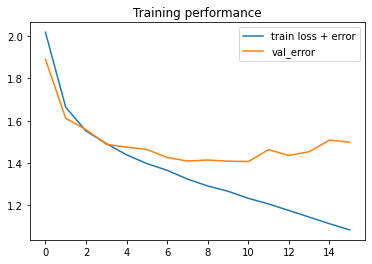

In [15]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

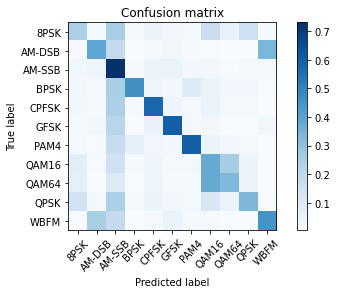

In [16]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08432392273402675


Overall Accuracy:  0.09020332717190388


Overall Accuracy:  0.10038882997525628


Overall Accuracy:  0.11349262122276879


Overall Accuracy:  0.1333092485549133


Overall Accuracy:  0.20766201217329036


Overall Accuracy:  0.2680042995342171


Overall Accuracy:  0.37318313953488375


Overall Accuracy:  0.4039758608448704


Overall Accuracy:  0.49640546369518335


Overall Accuracy:  0.6042120551924474


Overall Accuracy:  0.6649837720879913


Overall Accuracy:  0.7028462998102467


Overall Accuracy:  0.7130597014925373


Overall Accuracy:  0.7110951008645533


Overall Accuracy:  0.7305869485964273


Overall Accuracy:  0.7193631988152536


Overall Accuracy:  0.7476494922903347


Overall Accuracy:  0.7210759027266028


Overall Accuracy:  0.7236559139784946


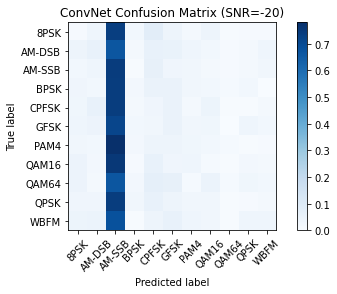

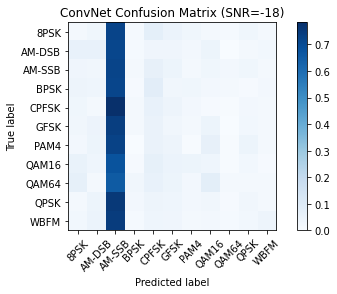

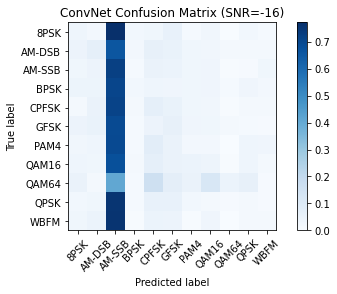

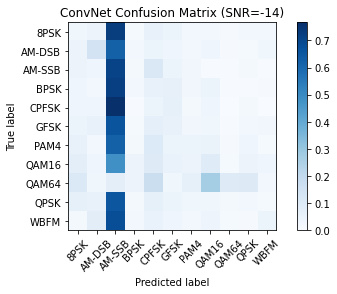

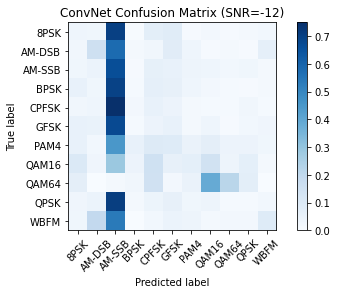

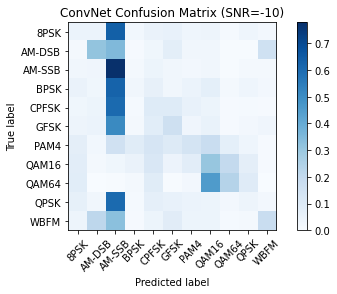

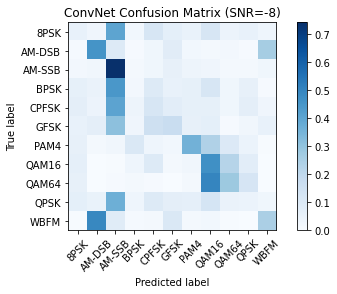

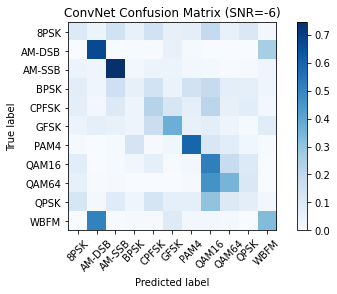

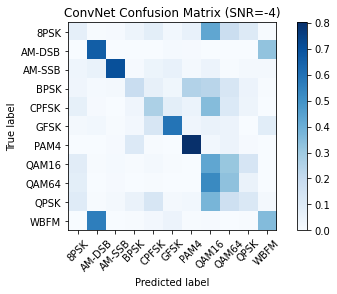

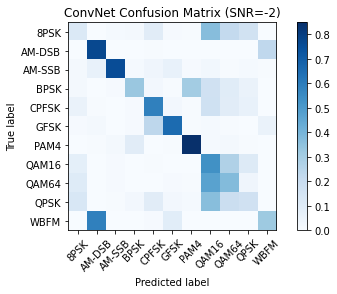

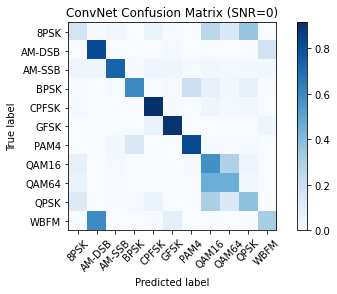

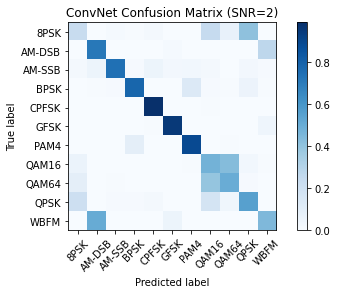

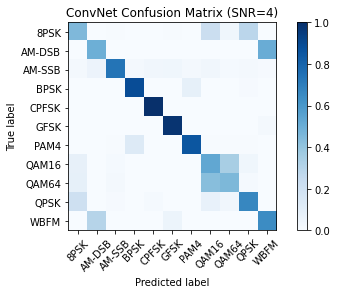

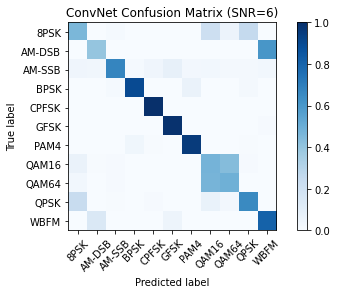

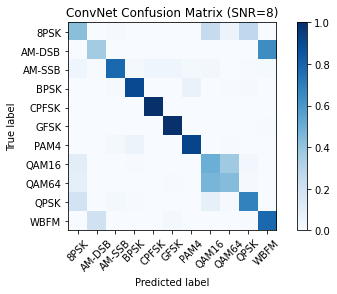

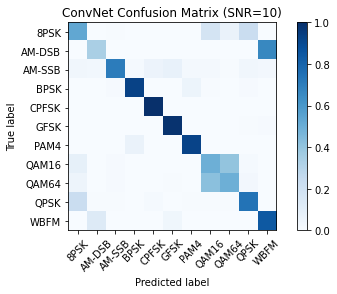

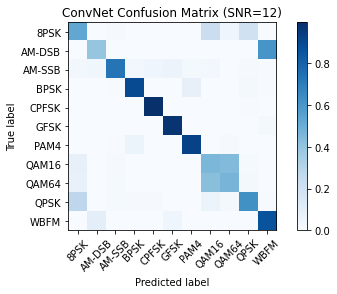

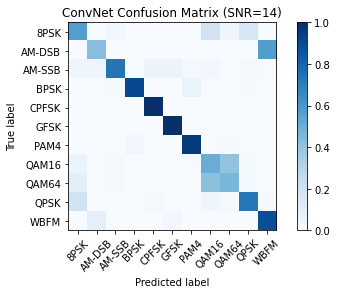

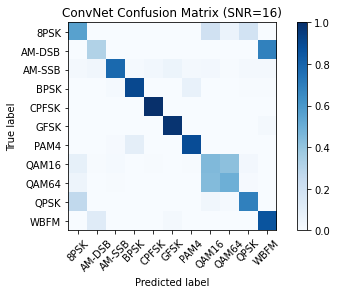

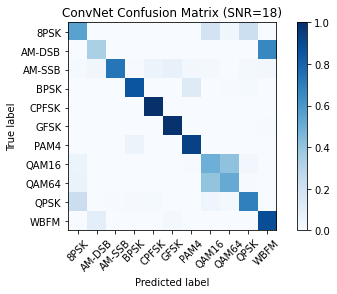

In [17]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [18]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,10,11,13,20,26,37,40,49,60,66,70,71,71,73,71,74,72,72


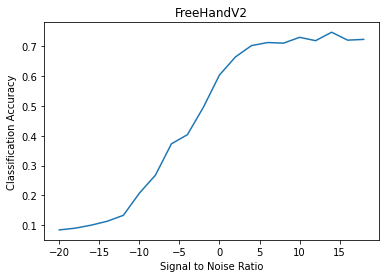

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)